# UMAP Performance Analysis: JavaScript vs WebAssembly Features

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Test Environment**: All benchmarks run on WSL2 (Windows Subsystem for Linux)
- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes

## 1. Setup and Data Loading

In [75]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [76]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head()

Total rows: 840
Columns: 33

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     840.000
mean      571.667
std       362.634
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,dataset_index,timestamp,dataset_name,dataset_size,dimensions,wasm_features,rendering_enabled,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:09.350Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2395.8,3.004,0.986,60.000,9.791
1,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:15.865Z,Small Random (80 points),80,10,none,False,3271.7,8.117,0.880,49.222,21.187
2,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:50.238Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2388.4,1.363,0.989,59.994,9.682
3,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:56.264Z,Small Random (80 points),80,10,none,False,3538.4,8.718,0.868,46.995,23.280
4,2026-02-06T11:20:33.775Z,10,3,39489,2026-02-06T11:22:12.441Z,25040.741,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:22:30.309Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2375.8,0.014,0.989,59.994,8.155


## 2. Data Cleaning and Preparation

In [77]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
# Handle comma-separated features (all features combined) and convert to lowercase
df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Identify machine types
df_clean['machine_type'] = df_clean['machine_platform'].map({
    'darwin': 'MacBook',
    'linux': 'Linux'
})

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name', 'machine_type'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nMachine distribution:")
print(df_clean['machine_type'].value_counts())
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())


After cleaning: 840 rows

Feature distribution:
feature_name
All Features     120
Baseline (JS)    120
Distance         120
Matrix           120
NN Descent       120
Optimizer        120
Tree             120
Name: count, dtype: int64

Machine distribution:
machine_type
Linux    840
Name: count, dtype: int64

Dataset distribution:
dataset_name
Iris Dataset (150 points, 4D)           140
Small Random (80 points)                140
Swiss Roll (600 points, 3D manifold)    140
Medium Clustered (600 points)           140
MNIST-like (1K points, 784D)            140
3D Dense Clusters (1K points)           140
Name: count, dtype: int64


In [78]:
# Create analysis dataset
df_analysis = df_clean.copy()

print(f"\n{'='*80}")
print(f"DATASET READY FOR ANALYSIS")
print(f"{'='*80}")
print(f"Total measurements: {len(df_analysis):,}")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {df_analysis['dataset_name'].nunique()}")
print(f"\nMeasurements per feature:")
print(df_analysis['feature_name'].value_counts().sort_index())


DATASET READY FOR ANALYSIS
Total measurements: 840
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: 6

Measurements per feature:
feature_name
All Features     120
Baseline (JS)    120
Distance         120
Matrix           120
NN Descent       120
Optimizer        120
Tree             120
Name: count, dtype: int64


## 4. Individual Feature Performance Metrics

Detailed analysis of each WASM feature's performance characteristics.

### 4.1 Baseline: Pure JavaScript Implementation

Performance metrics for the reference JavaScript-only implementation (no WASM features).

In [79]:
# Filter data for Baseline (Pure JS)
baseline_df = df_analysis[df_analysis['feature_name'] == 'Baseline (JS)'].copy()

print(f"{'='*80}")
print(f"BASELINE: Pure JavaScript Implementation (No WASM)")
print(f"{'='*80}")
print(f"Total measurements: {len(baseline_df)}")
print(f"Datasets covered: {baseline_df['dataset_name'].nunique()}")
print(f"Dataset names: {', '.join(sorted(baseline_df['dataset_name'].unique()))}")

# Runtime Metrics
print(f"\n{' Runtime (ms) ':=^80}")
runtime_stats = baseline_df['runtime_ms'].describe()
print(f"  Count:   {runtime_stats['count']:.0f}")
print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['runtime_ms'].median():.2f} ms")
print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
print(f"  Min:     {runtime_stats['min']:.2f} ms")
print(f"  Max:     {runtime_stats['max']:.2f} ms")
print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
print(f"  75th %:  {runtime_stats['75%']:.2f} ms")

# Memory Usage
print(f"\n{' Memory Usage (MB) ':=^80}")
memory_stats = baseline_df['memory_delta_mb'].describe()
print(f"  Count:   {memory_stats['count']:.0f}")
print(f"  Mean:    {memory_stats['mean']:.2f} MB")
print(f"  Median:  {baseline_df['memory_delta_mb'].median():.2f} MB")
print(f"  Std Dev: {memory_stats['std']:.2f} MB")
print(f"  Min:     {memory_stats['min']:.2f} MB")
print(f"  Max:     {memory_stats['max']:.2f} MB")

# Embedding Quality (Trustworthiness)
print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
quality_stats = baseline_df['trustworthiness'].describe()
print(f"  Count:   {quality_stats['count']:.0f}")
print(f"  Mean:    {quality_stats['mean']:.4f}")
print(f"  Median:  {baseline_df['trustworthiness'].median():.4f}")
print(f"  Std Dev: {quality_stats['std']:.4f}")
print(f"  Min:     {quality_stats['min']:.4f}")
print(f"  Max:     {quality_stats['max']:.4f}")

# Visualization FPS
print(f"\n{' Visualization FPS ':=^80}")
fps_stats = baseline_df['fps_avg'].describe()
print(f"  Count:   {fps_stats['count']:.0f}")
print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
print(f"  Median:  {baseline_df['fps_avg'].median():.2f} FPS")
print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
print(f"  Min:     {fps_stats['min']:.2f} FPS")
print(f"  Max:     {fps_stats['max']:.2f} FPS")

# Responsiveness
print(f"\n{' Responsiveness (ms) ':=^80}")
resp_stats = baseline_df['responsiveness_ms'].describe()
print(f"  Count:   {resp_stats['count']:.0f}")
print(f"  Mean:    {resp_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['responsiveness_ms'].median():.2f} ms")
print(f"  Std Dev: {resp_stats['std']:.2f} ms")
print(f"  Min:     {resp_stats['min']:.2f} ms")
print(f"  Max:     {resp_stats['max']:.2f} ms")

# Per-Dataset Summary
print(f"\n{' Per-Dataset Summary ':=^80}")
dataset_summary = baseline_df.groupby('dataset_name').agg({
    'runtime_ms': ['count', 'median', 'mean', 'std'],
    'memory_delta_mb': ['median', 'mean'],
    'trustworthiness': ['median', 'mean'],
    'fps_avg': ['median', 'mean'],
    'responsiveness_ms': ['median', 'mean']
}).round(3)

display(dataset_summary)

BASELINE: Pure JavaScript Implementation (No WASM)
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    3634.61 ms
  Median:  3575.50 ms
  Std Dev: 906.13 ms
  Min:     2316.50 ms
  Max:     6777.80 ms
  25th %:  2981.35 ms
  75th %:  4533.33 ms

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    11.79 MB
  Median:  13.33 MB
  Std Dev: 9.10 MB
  Min:     -7.00 MB
  Max:     39.47 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.9008
  Median:  0.9688
  Std Dev: 0.1386
  Min:     0.6010
  Max:     0.9975

============================== Visualization FPS =====================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                20  4714.40  4817.17  504.290          15.390  13.932           0.997   
Iris Dataset (150 points, 4D)                20  2375.50  2373.95   29.281           0.220   1.065           0.988   
MNIST-like (1K points, 784D)                 20  4648.20  4646.58  140.900          17.126  16.776           0.610   
Medium Clustered (600 points)                20  3749.65  3735.53   71.815          12.116  13.888           0.951   
Small Random (80 points)                     20  3275.50  3245.07  171.030           6.789   7.548           0.866   
Swiss Roll (600 points, 3D manifold)         20  2985.25  2989.35   37.976          17.432  17.502           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  49.089  49.433            30.470   29.935  
Iris Dataset (150 points, 4D)         0.988  60.000  60.000             8.523    8.282  
MNIST-like (1K points, 784D)          0.609  59.988  59.982           112.600  112.365  
Medium Clustered (600 points)         0.950  53.157  53.326            22.030   22.232  
Small Random (80 points)              0.866  48.200  48.256            20.937   21.335  
Swiss Roll (600 points, 3D manifold)  0.994  60.000  59.996            18.782   18.717

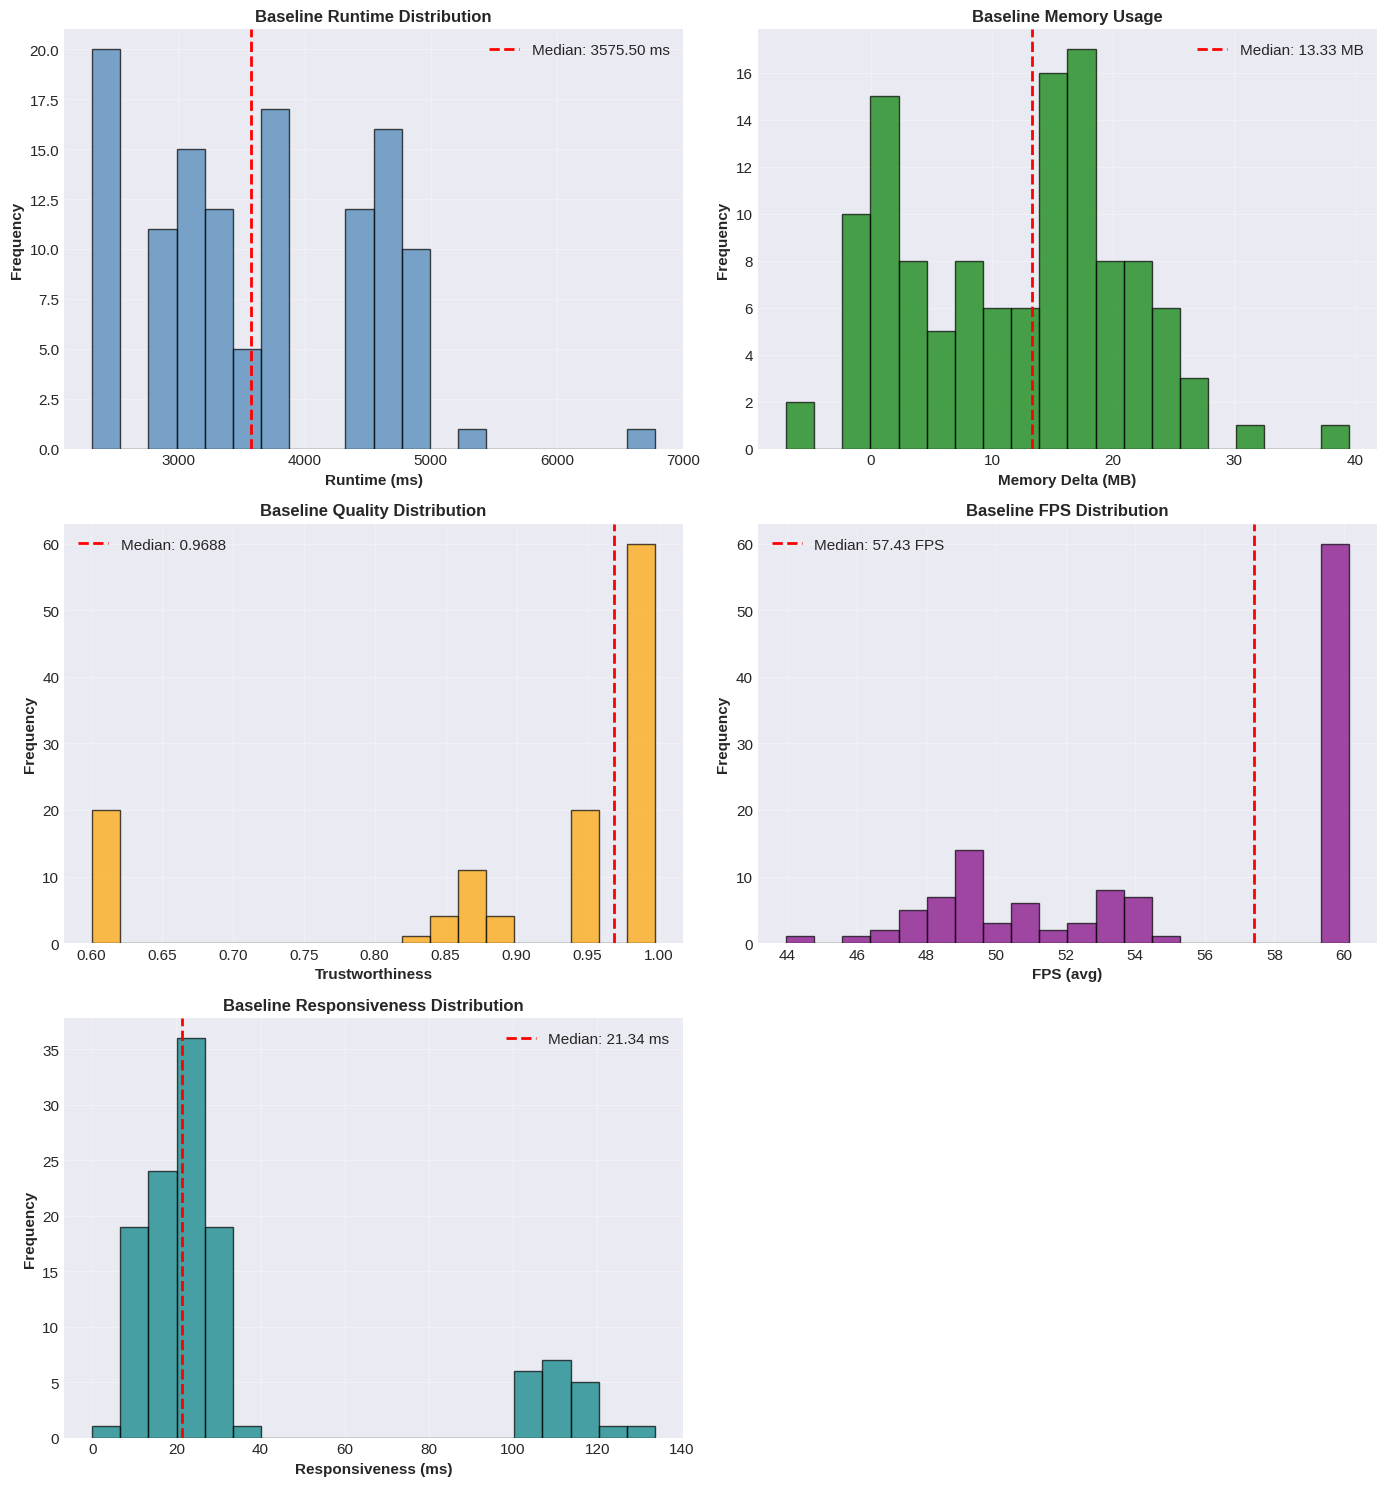

In [80]:
# Visualizations for Baseline
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Runtime distribution
axes[0, 0].hist(baseline_df['runtime_ms'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(baseline_df['runtime_ms'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["runtime_ms"].median():.2f} ms')
axes[0, 0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Baseline Runtime Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Memory usage
axes[0, 1].hist(baseline_df['memory_delta_mb'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(baseline_df['memory_delta_mb'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["memory_delta_mb"].median():.2f} MB')
axes[0, 1].set_xlabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Baseline Memory Usage', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Quality (Trustworthiness)
axes[1, 0].hist(baseline_df['trustworthiness'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(baseline_df['trustworthiness'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["trustworthiness"].median():.4f}')
axes[1, 0].set_xlabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Baseline Quality Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# FPS
axes[1, 1].hist(baseline_df['fps_avg'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(baseline_df['fps_avg'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["fps_avg"].median():.2f} FPS')
axes[1, 1].set_xlabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Baseline FPS Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Responsiveness
axes[2, 0].hist(baseline_df['responsiveness_ms'], bins=20, alpha=0.7, color='teal', edgecolor='black')
axes[2, 0].axvline(baseline_df['responsiveness_ms'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["responsiveness_ms"].median():.2f} ms')
axes[2, 0].set_xlabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Baseline Responsiveness Distribution', fontsize=12, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

# Hide unused subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline_metrics.png', bbox_inches='tight')
plt.show()


### 4.2 Distance Feature (WASM)

Performance metrics for WASM-accelerated distance calculations.

In [81]:
# Filter data for Distance feature
dist_df = df_analysis[df_analysis['feature_name'] == 'Distance'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Distance")
print(f"{'='*80}")
print(f"Total measurements: {len(dist_df)}")
print(f"Datasets covered: {dist_df['dataset_name'].nunique()}")
if len(dist_df) > 0:
    print(f"Dataset names: {', '.join(sorted(dist_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = dist_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        pct_change = ((dist_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = dist_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {dist_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = dist_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {dist_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = dist_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {dist_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = dist_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = dist_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Distance feature")

WASM FEATURE: Distance
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    3648.57 ms
  Median:  3570.95 ms
  Std Dev: 866.25 ms
  Min:     2319.20 ms
  Max:     5896.30 ms
  25th %:  2984.70 ms
  75th %:  4561.50 ms

  vs Baseline: 1.00x speedup (-0.1%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    10.85 MB
  Median:  12.13 MB
  Std Dev: 9.18 MB
  Min:     -8.78 MB
  Max:     42.08 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.9007
  Median:  0.9695
  Std Dev: 0.1389
  Min:     0.6019
  Max:     0.9974

============================== Visualization FPS ===========

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  4663.75  4712.315  307.411           8.721  10.450           0.997   
Iris Dataset (150 points, 4D)                20  2376.45  2381.260   29.955           1.963   2.269           0.989   
MNIST-like (1K points, 784D)                 20  4630.40  4687.165  211.026          16.296  16.188           0.608   
Medium Clustered (600 points)                20  3742.90  3729.715   94.764          17.792  13.828           0.950   
Small Random (80 points)                     20  3376.00  3373.610   97.947           0.881   5.241           0.864   
Swiss Roll (600 points, 3D manifold)         20  2984.70  3007.360   69.245          17.602  17.128           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  49.573  49.111            31.093   31.197  
Iris Dataset (150 points, 4D)         0.988  59.994  59.999             8.514    8.795  
MNIST-like (1K points, 784D)          0.609  59.988  59.987           110.832  113.252  
Medium Clustered (600 points)         0.951  53.137  53.204            21.513   21.969  
Small Random (80 points)              0.865  47.990  47.176            21.810   22.053  
Swiss Roll (600 points, 3D manifold)  0.994  60.002  60.004            18.418   18.364

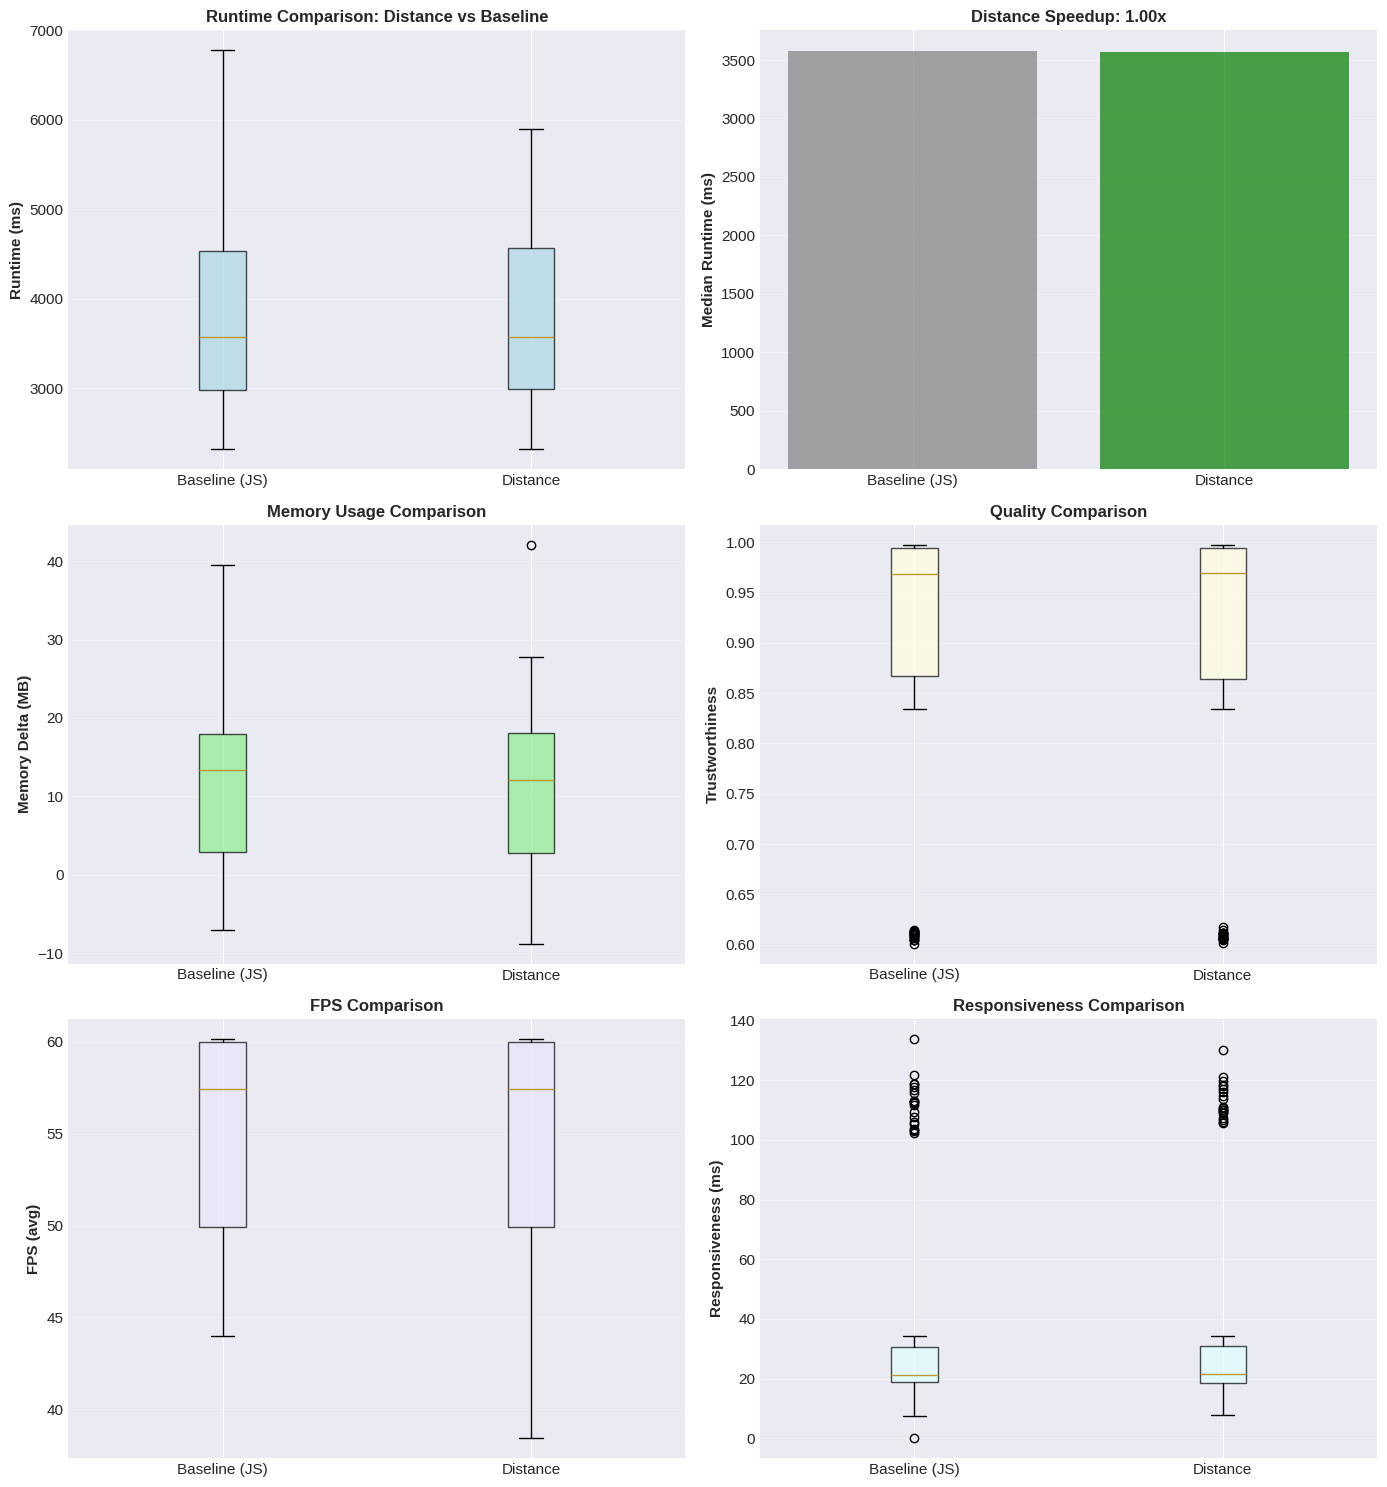

In [82]:
# Visualizations for Distance Feature
if len(dist_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    comparison_data = pd.DataFrame({
        'Baseline (JS)': baseline_df['runtime_ms'],
        'Distance': dist_df['runtime_ms']
    })
    axes[0, 0].boxplot([baseline_df['runtime_ms'], dist_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Distance vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Distance'], 
                      [baseline_median, dist_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Distance Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], dist_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], dist_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], dist_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], dist_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/distance_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.3 Tree Feature (WASM)

Performance metrics for WASM-accelerated tree operations.

In [83]:
# Filter data for Tree feature
tree_df = df_analysis[df_analysis['feature_name'] == 'Tree'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Tree")
print(f"{'='*80}")
print(f"Total measurements: {len(tree_df)}")
print(f"Datasets covered: {tree_df['dataset_name'].nunique()}")
if len(tree_df) > 0:
    print(f"Dataset names: {', '.join(sorted(tree_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = tree_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        pct_change = ((tree_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = tree_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {tree_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = tree_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {tree_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = tree_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {tree_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = tree_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = tree_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Tree feature")

WASM FEATURE: Tree
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    3572.82 ms
  Median:  3538.05 ms
  Std Dev: 841.07 ms
  Min:     2314.50 ms
  Max:     4968.20 ms
  25th %:  2973.65 ms
  75th %:  4372.40 ms

  vs Baseline: 1.01x speedup (-1.0%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    15.73 MB
  Median:  12.55 MB
  Std Dev: 14.89 MB
  Min:     -18.60 MB
  Max:     60.22 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.9004
  Median:  0.9679
  Std Dev: 0.1389
  Min:     0.6025
  Max:     0.9975

============================== Visualization FPS =============

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  4659.20  4622.310  215.667           5.481   5.885           0.997   
Iris Dataset (150 points, 4D)                20  2370.20  2367.440   23.464           3.118   4.457           0.989   
MNIST-like (1K points, 784D)                 20  4612.80  4552.365  183.945          43.857  43.020           0.609   
Medium Clustered (600 points)                20  3762.15  3771.645  147.891          12.424  13.900           0.951   
Small Random (80 points)                     20  3017.75  3111.140  166.729           8.690   8.995           0.864   
Swiss Roll (600 points, 3D manifold)         20  2996.55  3012.020   64.282          18.662  18.147           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.197  50.050            31.697   31.291  
Iris Dataset (150 points, 4D)         0.988  59.999  59.998             8.186    7.991  
MNIST-like (1K points, 784D)          0.609  59.981  59.977           104.300  105.295  
Medium Clustered (600 points)         0.950  53.152  53.314            22.557   22.650  
Small Random (80 points)              0.863  47.993  48.064            20.120   20.185  
Swiss Roll (600 points, 3D manifold)  0.994  60.000  60.005            18.032   18.173

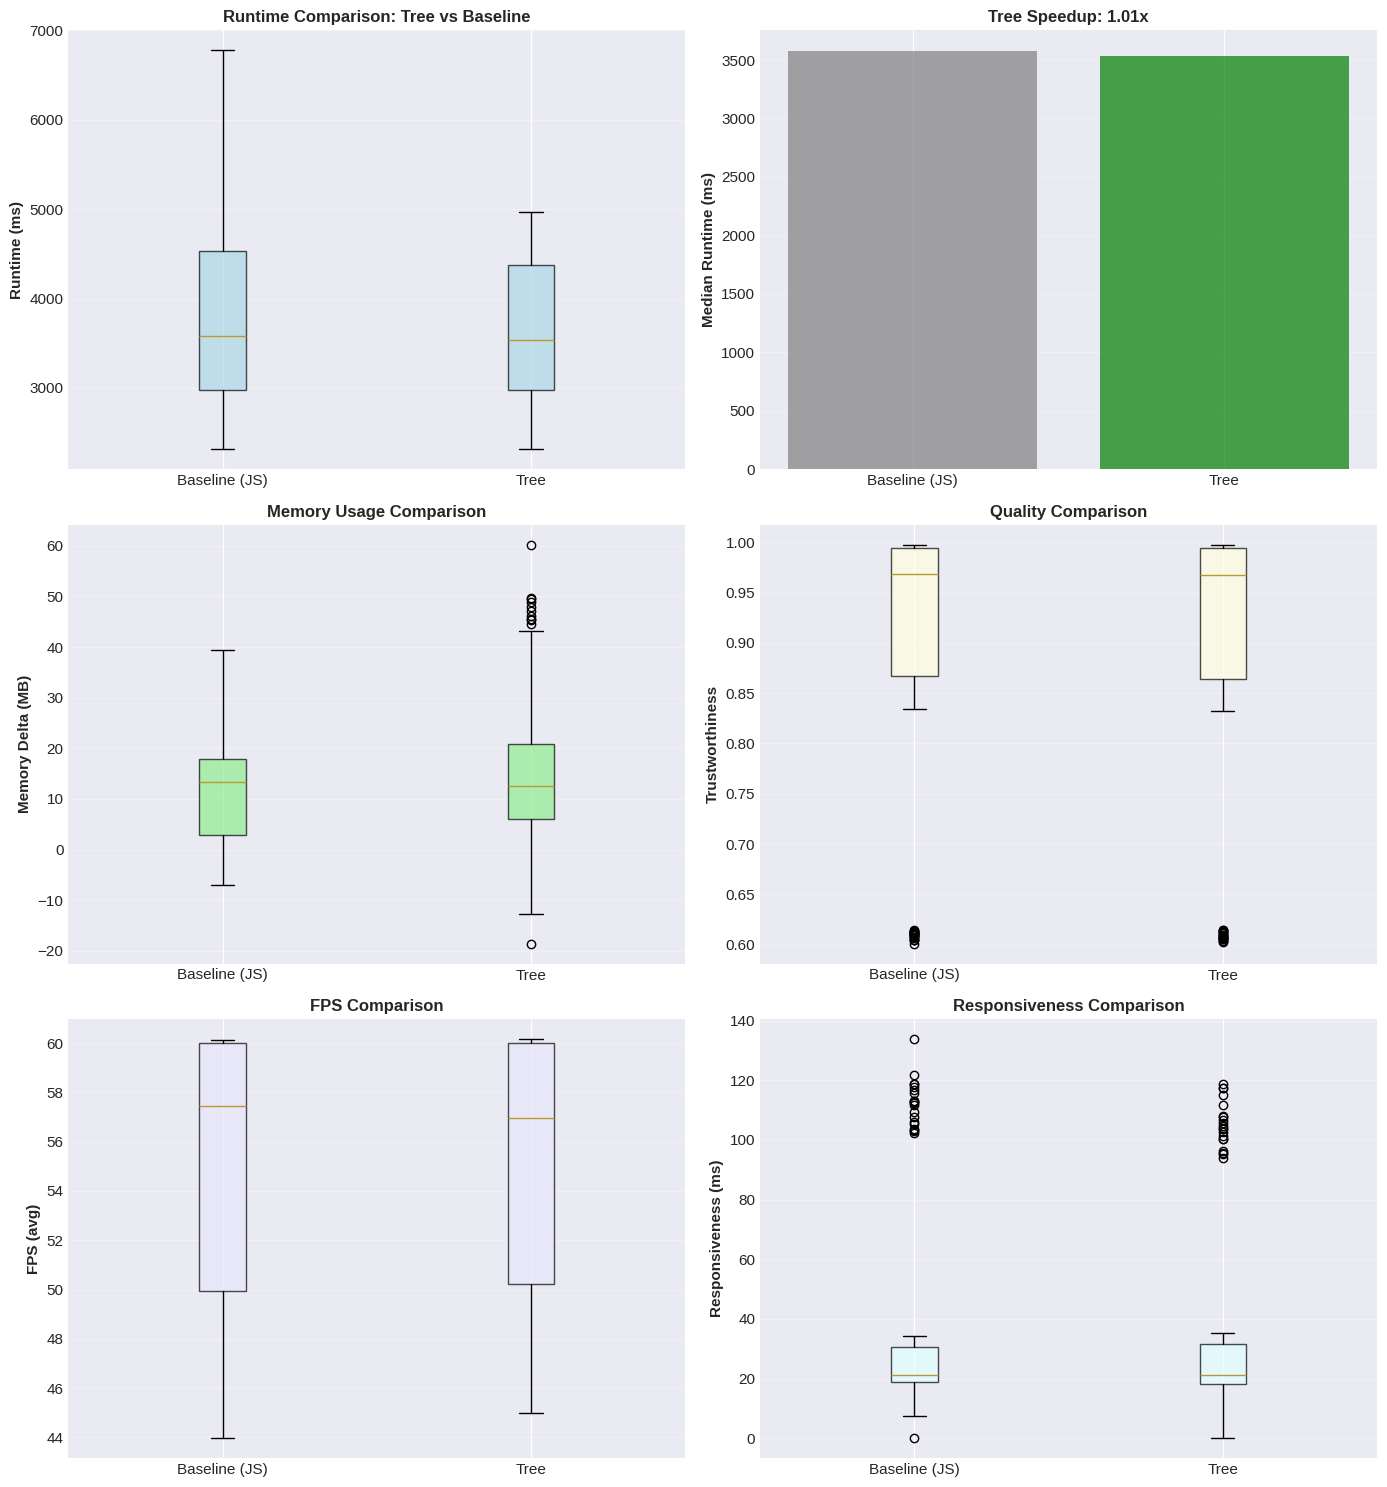

In [84]:
# Visualizations for Tree Feature
if len(tree_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], tree_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Tree vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Tree'], 
                      [baseline_median, tree_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Tree Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], tree_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], tree_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], tree_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], tree_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/tree_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.4 Matrix Feature (WASM)

Performance metrics for WASM-accelerated matrix operations.

In [85]:
# Filter data for NN Descent feature
nn_df = df_analysis[df_analysis['feature_name'] == 'NN Descent'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: NN Descent")
print(f"{'='*80}")
print(f"Total measurements: {len(nn_df)}")
print(f"Datasets covered: {nn_df['dataset_name'].nunique()}")
if len(nn_df) > 0:
    print(f"Dataset names: {', '.join(sorted(nn_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = nn_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        pct_change = ((nn_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = nn_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {nn_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = nn_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {nn_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = nn_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {nn_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = nn_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = nn_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for NN Descent feature")

WASM FEATURE: NN Descent
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    3627.07 ms
  Median:  3489.85 ms
  Std Dev: 875.94 ms
  Min:     2365.60 ms
  Max:     5295.80 ms
  25th %:  2969.80 ms
  75th %:  4582.40 ms

  vs Baseline: 1.02x speedup (-2.4%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    18.15 MB
  Median:  16.87 MB
  Std Dev: 12.26 MB
  Min:     -8.42 MB
  Max:     48.06 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.8992
  Median:  0.9698
  Std Dev: 0.1408
  Min:     0.5986
  Max:     0.9974

============================== Visualization FPS ========

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  4645.60  4663.495  184.718          14.137  14.224           0.997   
Iris Dataset (150 points, 4D)                20  2383.90  2386.580   18.886           7.877   7.234           0.989   
MNIST-like (1K points, 784D)                 20  4754.10  4752.245  183.226          34.702  36.200           0.604   
Medium Clustered (600 points)                20  3754.00  3746.315  124.281          13.212  14.427           0.952   
Small Random (80 points)                     20  3275.75  3191.770  184.049          11.748  12.173           0.862   
Swiss Roll (600 points, 3D manifold)         20  3014.35  3022.040   72.218          25.010  24.627           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.148  49.722            28.573   28.582  
Iris Dataset (150 points, 4D)         0.989  59.998  59.998             8.823    9.143  
MNIST-like (1K points, 784D)          0.604  59.971  59.983           114.464  114.338  
Medium Clustered (600 points)         0.951  53.137  52.928            21.797   21.680  
Small Random (80 points)              0.860  48.100  47.948            20.030   20.182  
Swiss Roll (600 points, 3D manifold)  0.994  60.004  59.994            18.218   18.455

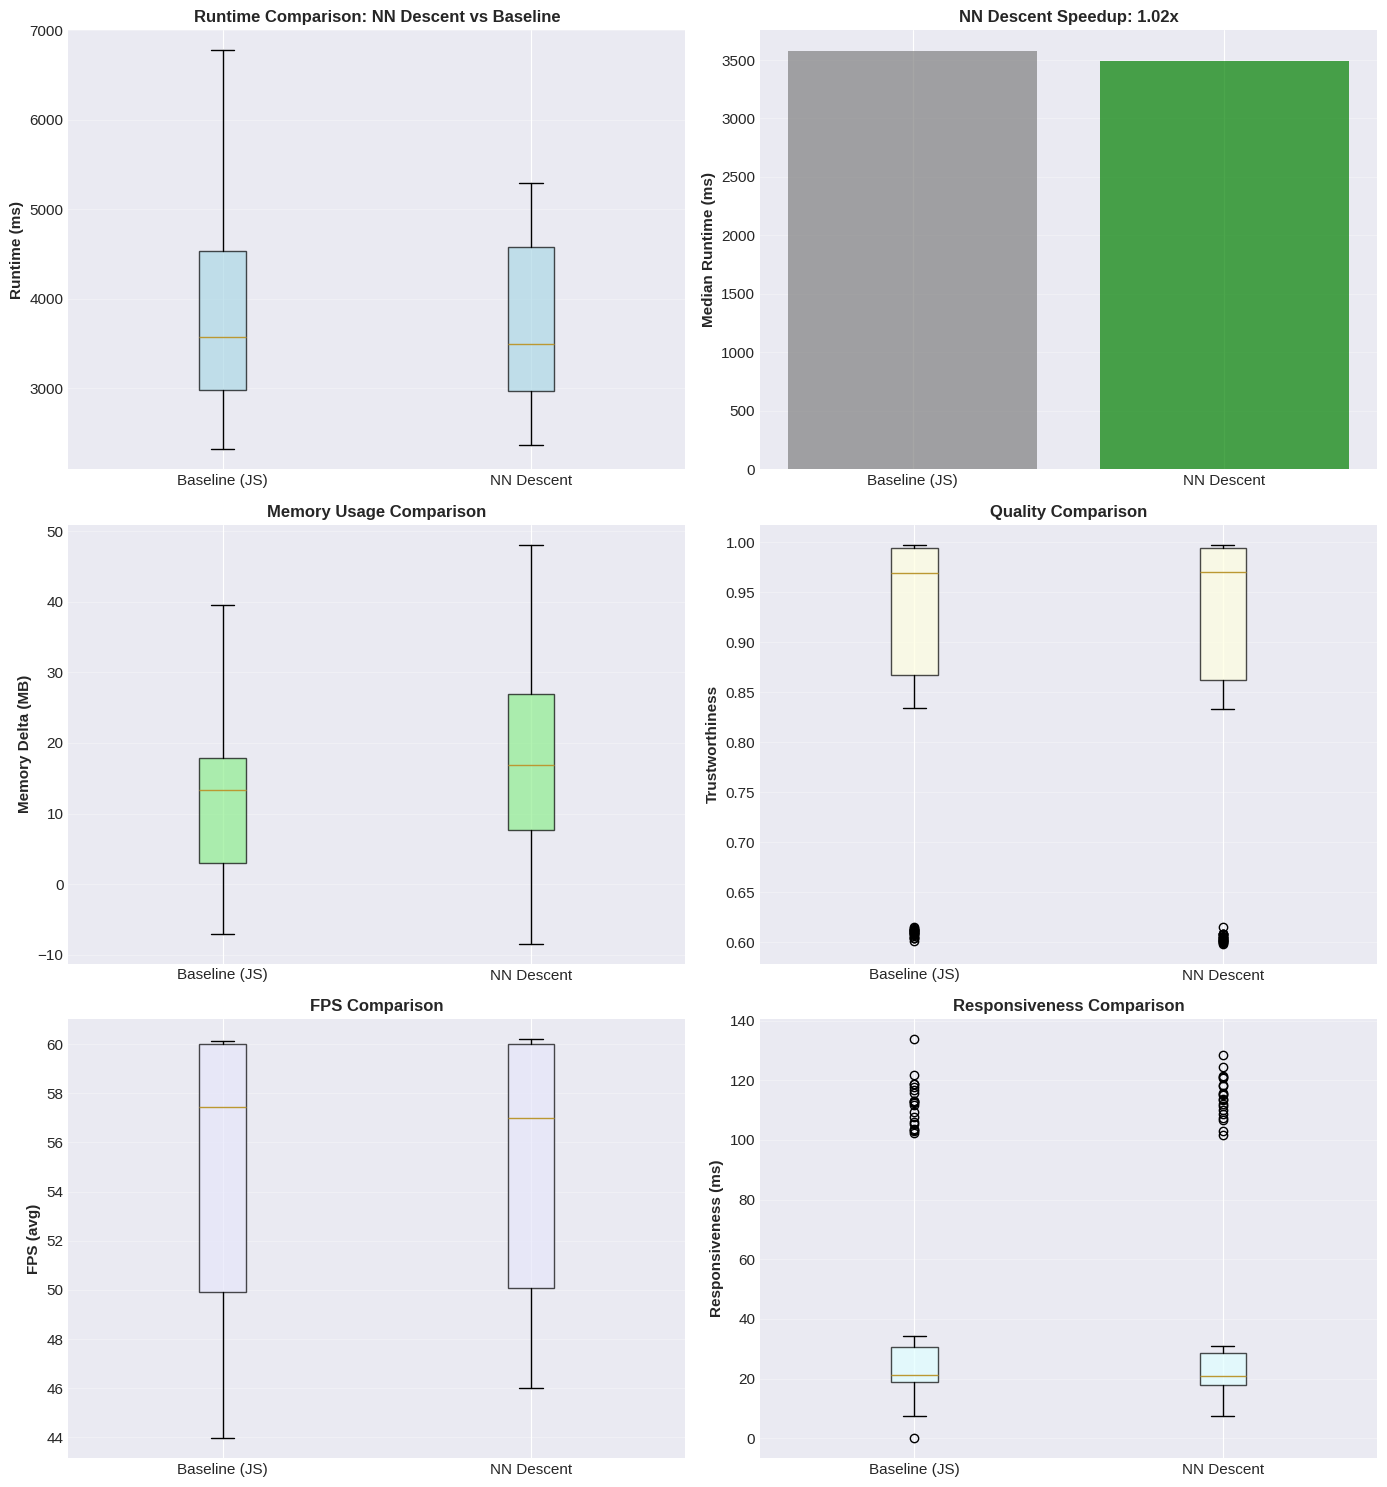

In [86]:
# Visualizations for NN Descent Feature
if len(nn_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], nn_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: NN Descent vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        
        axes[0, 1].bar(['Baseline (JS)', 'NN Descent'], 
                      [baseline_median, nn_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'NN Descent Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], nn_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], nn_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], nn_df['fps_avg']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], nn_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/nn_descent_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.6 Optimizer Feature (WASM)

Performance metrics for WASM-accelerated optimization.

In [87]:
# Filter data for All Features
all_df = df_analysis[df_analysis['feature_name'] == 'All Features'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: All Features Combined")
print(f"{'='*80}")
print(f"Total measurements: {len(all_df)}")
print(f"Datasets covered: {all_df['dataset_name'].nunique()}")
if len(all_df) > 0:
    print(f"Dataset names: {', '.join(sorted(all_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = all_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        pct_change = ((all_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = all_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {all_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = all_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {all_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = all_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {all_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = all_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = all_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for All Features")

WASM FEATURE: All Features Combined
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    2113.63 ms
  Median:  1868.60 ms
  Std Dev: 1249.66 ms
  Min:     609.20 ms
  Max:     4111.70 ms
  25th %:  755.27 ms
  75th %:  3477.95 ms

  vs Baseline: 1.91x speedup (-47.7%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    10.88 MB
  Median:  12.57 MB
  Std Dev: 11.77 MB
  Min:     -10.44 MB
  Max:     35.88 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.8898
  Median:  0.9663
  Std Dev: 0.1528
  Min:     0.5609
  Max:     0.9974

============================== Visualization 

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  3486.70  3473.835   99.064           4.954   7.507           0.997   
Iris Dataset (150 points, 4D)                20   661.30   661.795   29.169          13.044  12.879           0.985   
MNIST-like (1K points, 784D)                 20  3887.80  3903.810  114.131          28.638  28.839           0.571   
Medium Clustered (600 points)                20  2268.65  2239.780  188.545           1.862   4.085           0.949   
Small Random (80 points)                     20   752.05   761.615   32.855          -5.387  -3.466           0.845   
Swiss Roll (600 points, 3D manifold)         20  1647.85  1640.940   68.924          17.747  15.416           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  35.717  35.856            26.567   26.581  
Iris Dataset (150 points, 4D)         0.985   0.000   0.000            10.105   10.043  
MNIST-like (1K points, 784D)          0.571  37.941  38.149           103.805  103.684  
Medium Clustered (600 points)         0.949  47.452  44.812            18.920   18.851  
Small Random (80 points)              0.843   0.000   0.000            20.543   21.087  
Swiss Roll (600 points, 3D manifold)  0.994  48.565  48.502            15.223   15.039

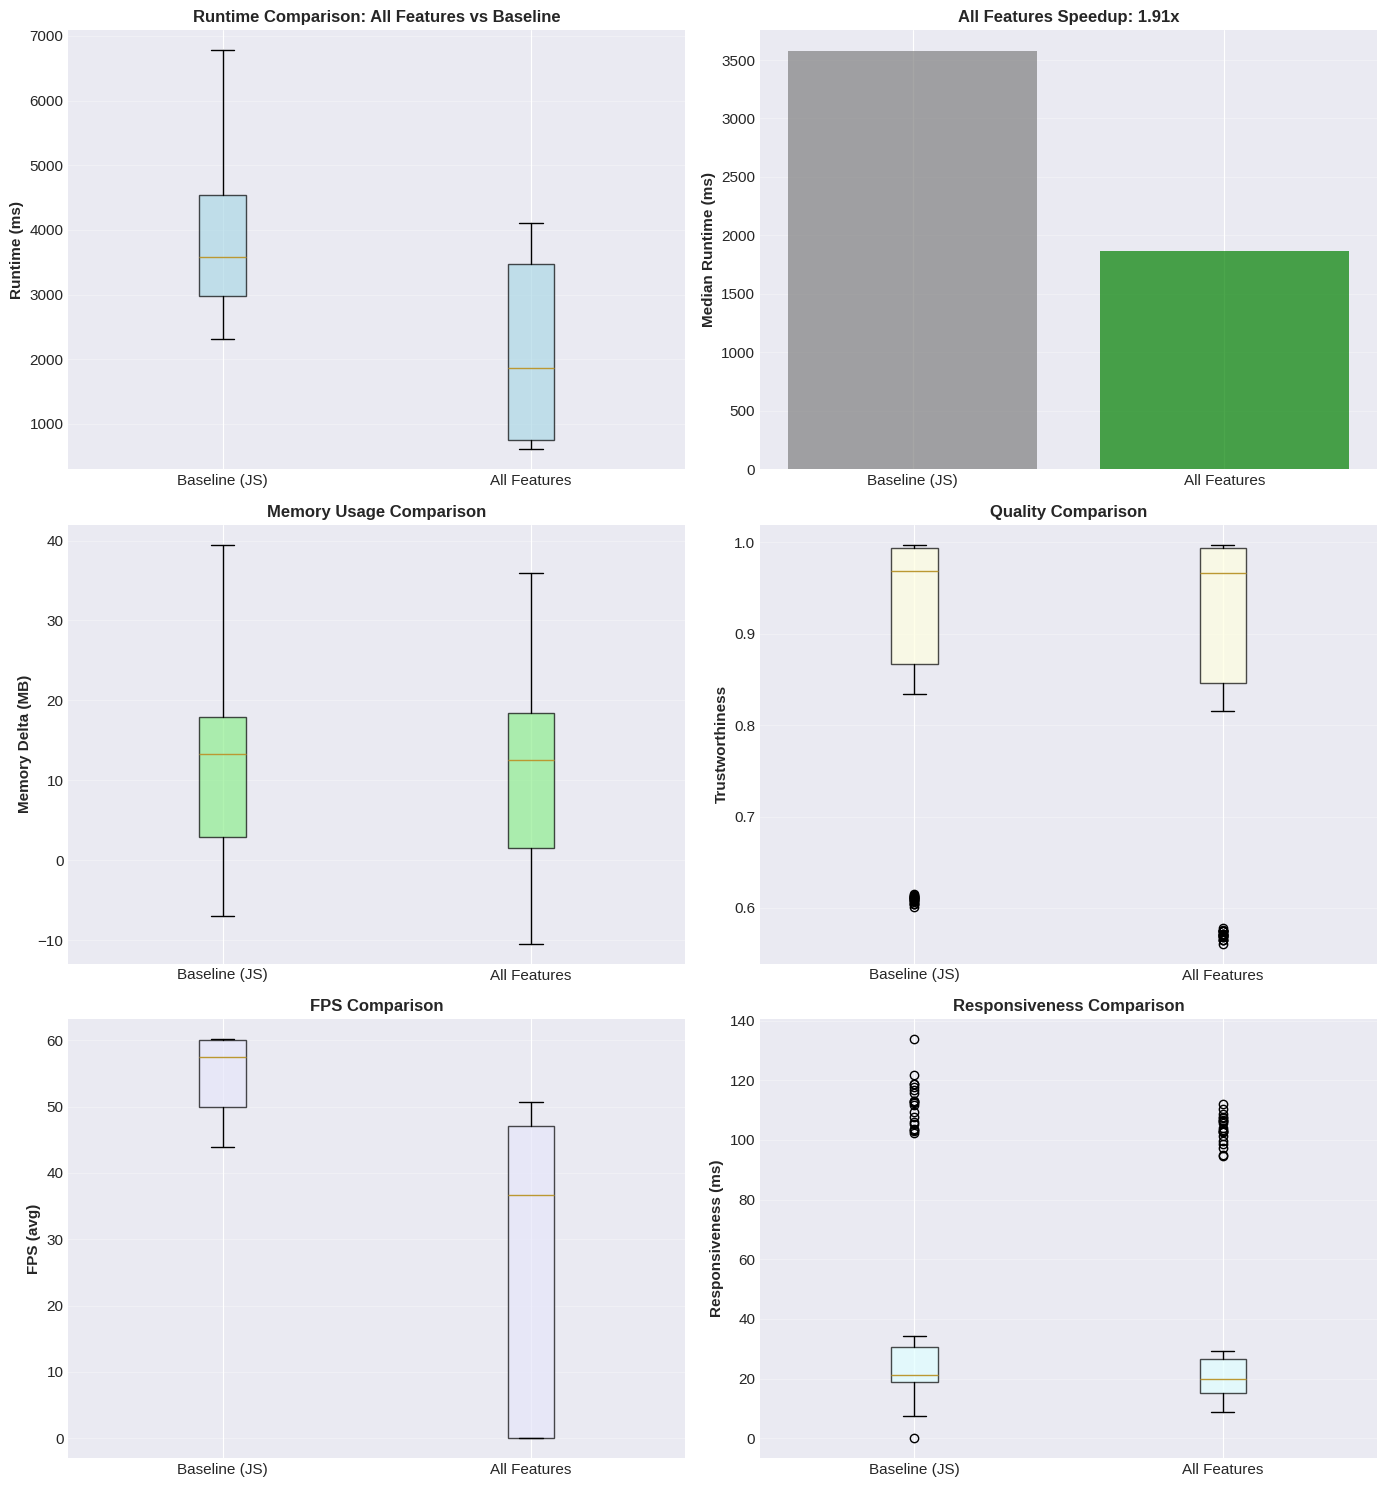

In [88]:
# Visualizations for All Features Combined
if len(all_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], all_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: All Features vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        
        axes[0, 1].bar(['Baseline (JS)', 'All Features'], 
                      [baseline_median, all_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'All Features Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], all_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], all_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], all_df['fps_avg']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], all_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/all_features_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


In [89]:
# Filter data for Optimizer feature
opt_df = df_analysis[df_analysis['feature_name'] == 'Optimizer'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Optimizer")
print(f"{'='*80}")
print(f"Total measurements: {len(opt_df)}")
print(f"Datasets covered: {opt_df['dataset_name'].nunique()}")
if len(opt_df) > 0:
    print(f"Dataset names: {', '.join(sorted(opt_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = opt_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        pct_change = ((opt_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = opt_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {opt_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = opt_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {opt_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = opt_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {opt_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = opt_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = opt_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Optimizer feature")

WASM FEATURE: Optimizer
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    2159.70 ms
  Median:  2039.30 ms
  Std Dev: 1290.99 ms
  Min:     602.60 ms
  Max:     4558.50 ms
  25th %:  722.67 ms
  75th %:  3559.05 ms

  vs Baseline: 1.75x speedup (-43.0%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    7.41 MB
  Median:  5.28 MB
  Std Dev: 7.75 MB
  Min:     -8.34 MB
  Max:     25.21 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.8881
  Median:  0.9667
  Std Dev: 0.1556
  Min:     0.5515
  Max:     0.9974

============================== Visualization FPS ============

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  3559.60  3565.375  314.487           6.701   8.402           0.997   
Iris Dataset (150 points, 4D)                20   619.50   622.500   19.204           0.067   0.076           0.986   
MNIST-like (1K points, 784D)                 20  3944.40  3922.085  180.707           4.833   4.370           0.564   
Medium Clustered (600 points)                20  2472.50  2414.875  156.802          12.268  12.864           0.948   
Small Random (80 points)                     20   722.45   731.950   34.458           1.356   2.058           0.840   
Swiss Roll (600 points, 3D manifold)         20  1741.40  1701.420   93.245          15.234  16.671           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  35.853  35.743            30.770   31.130  
Iris Dataset (150 points, 4D)         0.986   0.000   0.000             8.027    6.950  
MNIST-like (1K points, 784D)          0.563  39.285  39.168           112.286  113.495  
Medium Clustered (600 points)         0.948  47.105  47.208            22.747   23.105  
Small Random (80 points)              0.840   0.000   0.000            19.290   19.619  
Swiss Roll (600 points, 3D manifold)  0.994  45.844  46.070            18.545   18.483

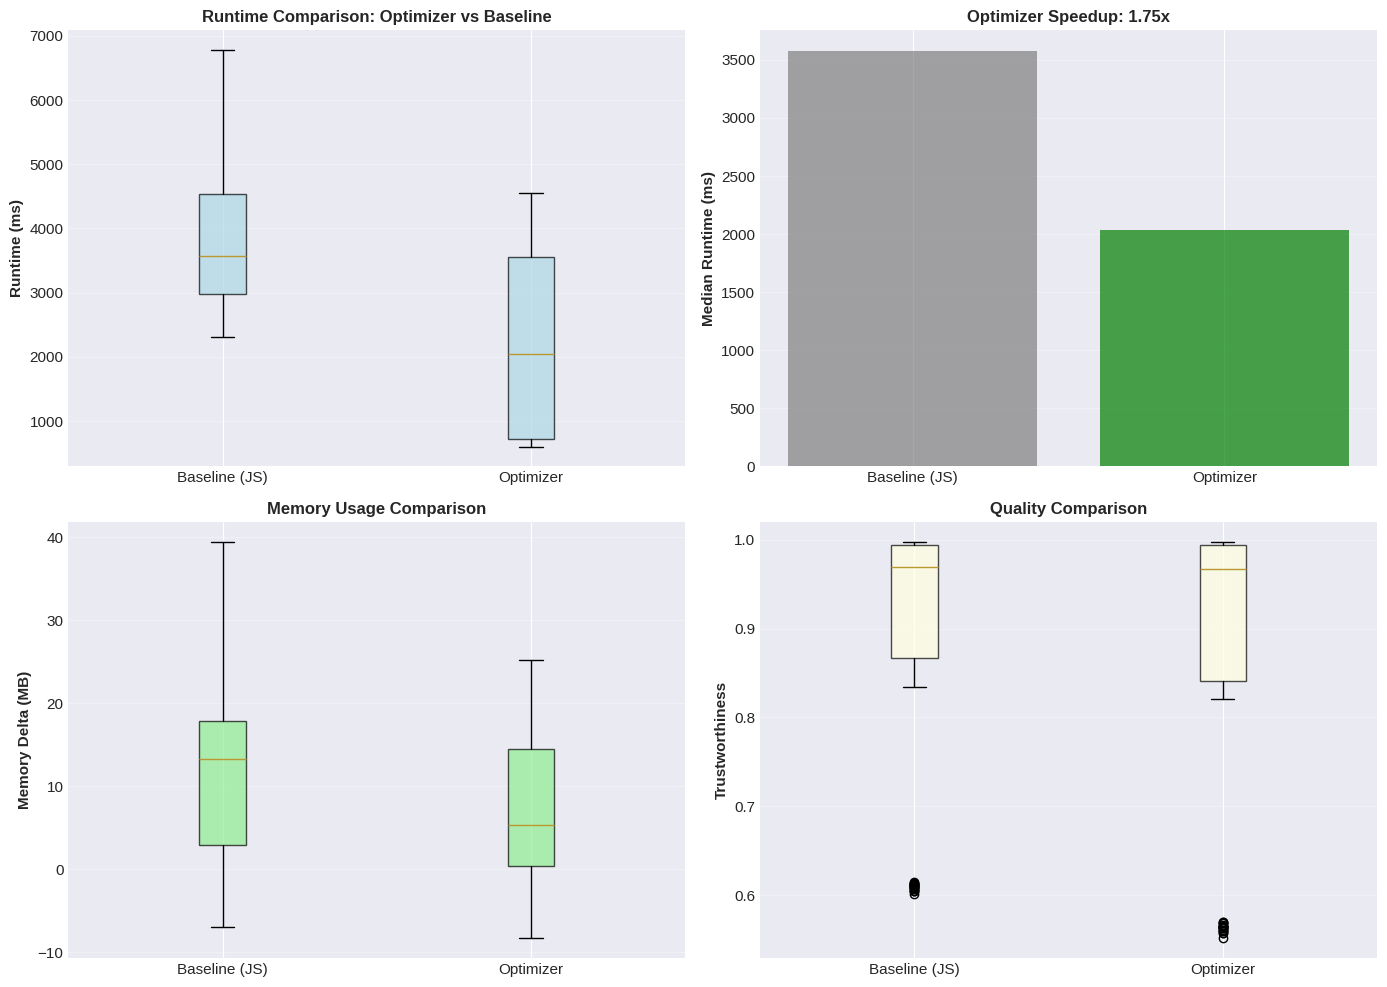

In [90]:
# Visualizations for Optimizer Feature
if len(opt_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], opt_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Optimizer vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Optimizer'], 
                      [baseline_median, opt_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Optimizer Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], opt_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], opt_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/optimizer_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.7 All Features Combined (WASM)

Performance metrics for all WASM features enabled simultaneously.

In [91]:
# Filter data for Matrix feature
matrix_df = df_analysis[df_analysis['feature_name'] == 'Matrix'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Matrix")
print(f"{'='*80}")
print(f"Total measurements: {len(matrix_df)}")
print(f"Datasets covered: {matrix_df['dataset_name'].nunique()}")
if len(matrix_df) > 0:
    print(f"Dataset names: {', '.join(sorted(matrix_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = matrix_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        pct_change = ((matrix_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = matrix_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {matrix_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = matrix_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {matrix_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = matrix_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {matrix_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = matrix_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = matrix_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Matrix feature")

WASM FEATURE: Matrix
Total measurements: 120
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   120
  Mean:    3576.03 ms
  Median:  3438.10 ms
  Std Dev: 860.00 ms
  Min:     2312.30 ms
  Max:     5072.70 ms
  25th %:  2960.73 ms
  75th %:  4440.82 ms

  vs Baseline: 1.04x speedup (-3.8%)

============================== Memory Usage (MB) ===============================
  Count:   120
  Mean:    13.66 MB
  Median:  13.05 MB
  Std Dev: 10.28 MB
  Min:     -17.46 MB
  Max:     40.21 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   120
  Mean:    0.8999
  Median:  0.9696
  Std Dev: 0.1395
  Min:     0.6011
  Max:     0.9975

============================== Visualization FPS ===========

runtime_ms                             memory_delta_mb         trustworthiness  \
                                          count   median      mean      std          median    mean          median   
dataset_name                                                                                                          
3D Dense Clusters (1K points)                20  4640.85  4596.210  167.801          12.806  10.542           0.997   
Iris Dataset (150 points, 4D)                20  2359.70  2367.320   35.092           4.183   5.975           0.989   
MNIST-like (1K points, 784D)                 20  4655.65  4661.015  217.020          29.093  27.282           0.608   
Medium Clustered (600 points)                20  3706.60  3737.025  175.169          15.727  14.910           0.951   
Small Random (80 points)                     20  3011.95  3111.430  158.203           5.875   7.405           0.863   
Swiss Roll (600 points, 3D manifold)         20  2977.95  2983.185   55.240          17.445  15.846           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  49.500  49.589            28.247   28.482  
Iris Dataset (150 points, 4D)         0.988  59.996  60.000             8.064    6.900  
MNIST-like (1K points, 784D)          0.608  60.002  59.984           108.068  106.941  
Medium Clustered (600 points)         0.951  53.152  52.969            20.223   20.792  
Small Random (80 points)              0.862  48.609  48.712            19.850   19.967  
Swiss Roll (600 points, 3D manifold)  0.994  59.999  60.003            16.359   16.278

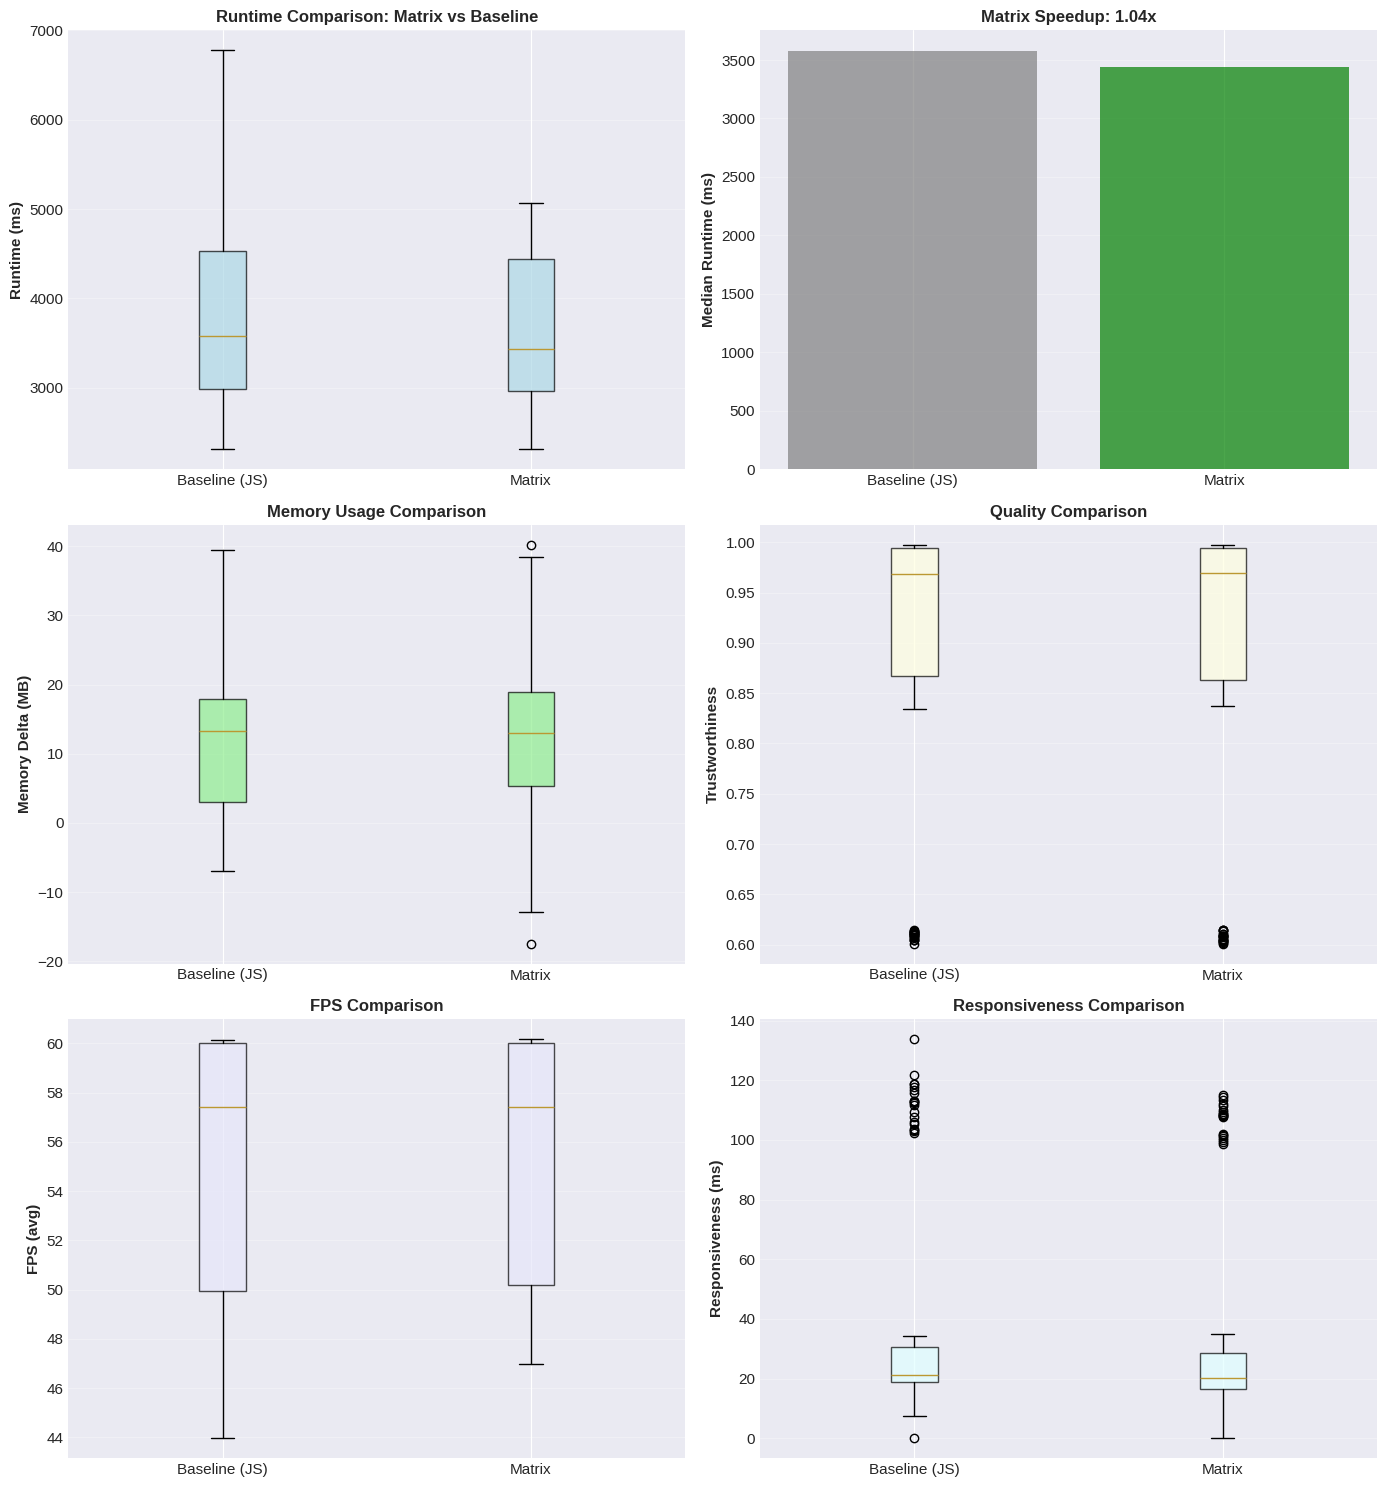

In [92]:
# Visualizations for Matrix Feature
if len(matrix_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], matrix_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Matrix vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Matrix'], 
                      [baseline_median, matrix_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Matrix Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], matrix_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], matrix_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], matrix_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], matrix_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/matrix_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.5 NN Descent Feature (WASM)

Performance metrics for WASM-accelerated nearest neighbor descent.

In [93]:
# Data Quality Checks
print("Data Quality Checks:")
print(f"Negative runtime values: {(df_analysis['runtime_ms'] < 0).sum()}")
print(f"Trustworthiness out of range [0,1]: {(~df_analysis['trustworthiness'].between(0, 1)).sum()}")
print(f"Negative FPS: {(df_analysis['fps_avg'] < 0).sum()}")
print(f"\nRuntime statistics by feature:")
df_analysis.groupby('feature_name')['runtime_ms'].describe()

Data Quality Checks:
Negative runtime values: 0
Trustworthiness out of range [0,1]: 0
Negative FPS: 0

Runtime statistics by feature:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
All Features,120.0,2113.629,1249.661,609.2,755.275,1868.60,3477.950,4111.7
Baseline (JS),120.0,3634.608,906.133,2316.5,2981.350,3575.50,4533.325,6777.8
Distance,120.0,3648.571,866.247,2319.2,2984.700,3570.95,4561.500,5896.3
Matrix,120.0,3576.031,860.004,2312.3,2960.725,3438.10,4440.825,5072.7
NN Descent,120.0,3627.074,875.937,2365.6,2969.800,3489.85,4582.400,5295.8
Optimizer,120.0,2159.701,1290.989,602.6,722.675,2039.30,3559.050,4558.5
Tree,120.0,3572.820,841.070,2314.5,2973.650,3538.05,4372.400,4968.2


## 5. Performance Distribution Analysis

Analyze the performance distribution across different features for the selected machine.

In [94]:
# Summary statistics by feature
feature_summary = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'memory_delta_mb': ['mean', 'median'],
    'trustworthiness': ['mean', 'median'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(2)

print("Performance Summary:")
feature_summary

Performance Summary:


runtime_ms                                            memory_delta_mb        trustworthiness         \
                   count     mean      std   median     min     max            mean median            mean median   
feature_name                                                                                                        
All Features         120  2113.63  1249.66  1868.60   609.2  4111.7           10.88  12.57            0.89   0.97   
Baseline (JS)        120  3634.61   906.13  3575.50  2316.5  6777.8           11.79  13.33            0.90   0.97   
Distance             120  3648.57   866.25  3570.95  2319.2  5896.3           10.85  12.13            0.90   0.97   
Matrix               120  3576.03   860.00  3438.10  2312.3  5072.7           13.66  13.05            0.90   0.97   
NN Descent           120  3627.07   875.94  3489.85  2365.6  5295.8           18.15  16.87            0.90   0.97   
Optimizer            120  2159.70  1290.99  2039.30   602.6  4558.5            7.41   5.28            0.89   0.97   
Tree                 120  3572.82   841.07  3538.05  2314.5  4968.2           15.73  12.55            0.90   0.97   

              fps_avg        responsiveness_ms         
                 mean median              mean median  
feature_name                                           
All Features    27.89  36.65             32.55  19.85  
Baseline (JS)   55.17  57.43             35.48  21.34  
Distance        54.91  57.45             35.94  21.61  
Matrix          55.21  57.43             33.23  20.14  
NN Descent      55.10  57.00             35.40  20.70  
Optimizer       28.03  37.61             35.46  21.04  
Tree            55.23  56.98             34.26  21.17

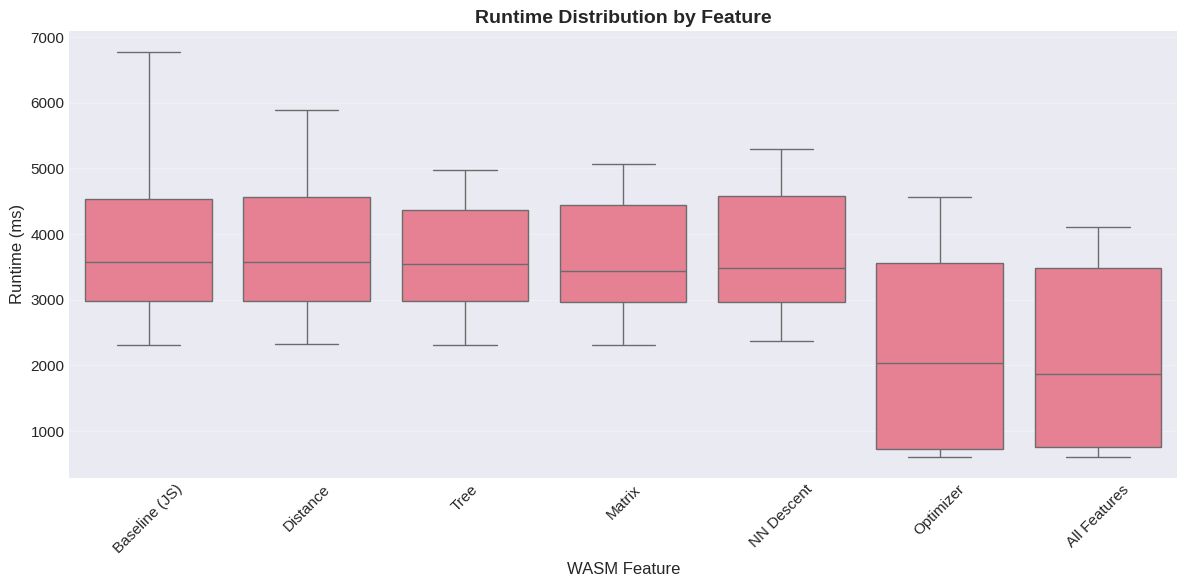

In [95]:
# Visualize runtime distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('Runtime Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Runtime (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight')
plt.show()

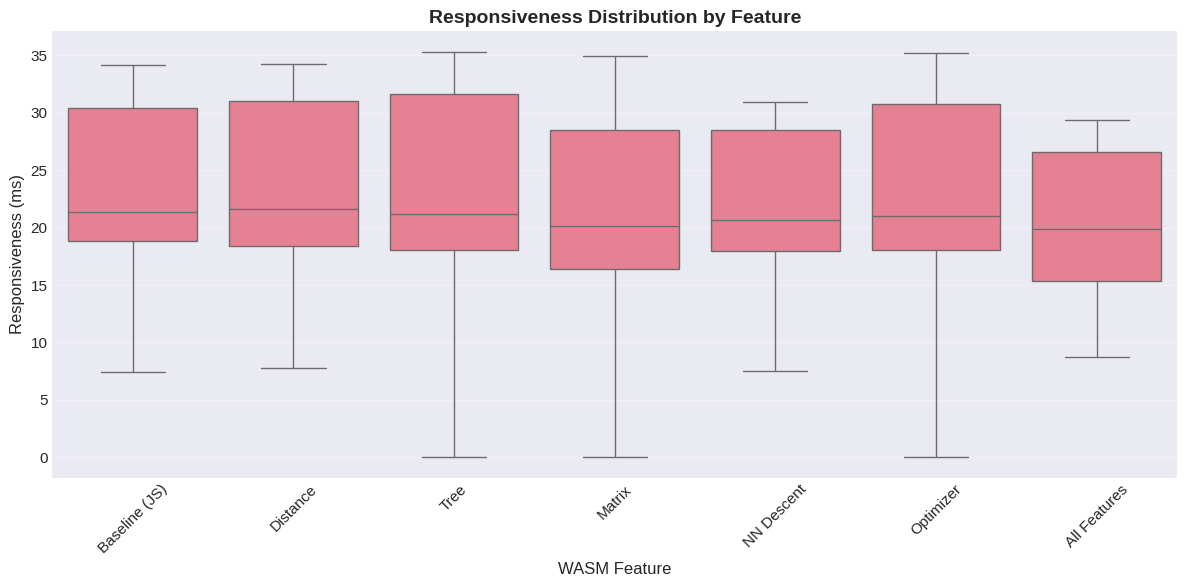

In [96]:
# Visualize responsiveness distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('Responsiveness Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Responsiveness (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/responsiveness_distribution.png', bbox_inches='tight')
plt.show()


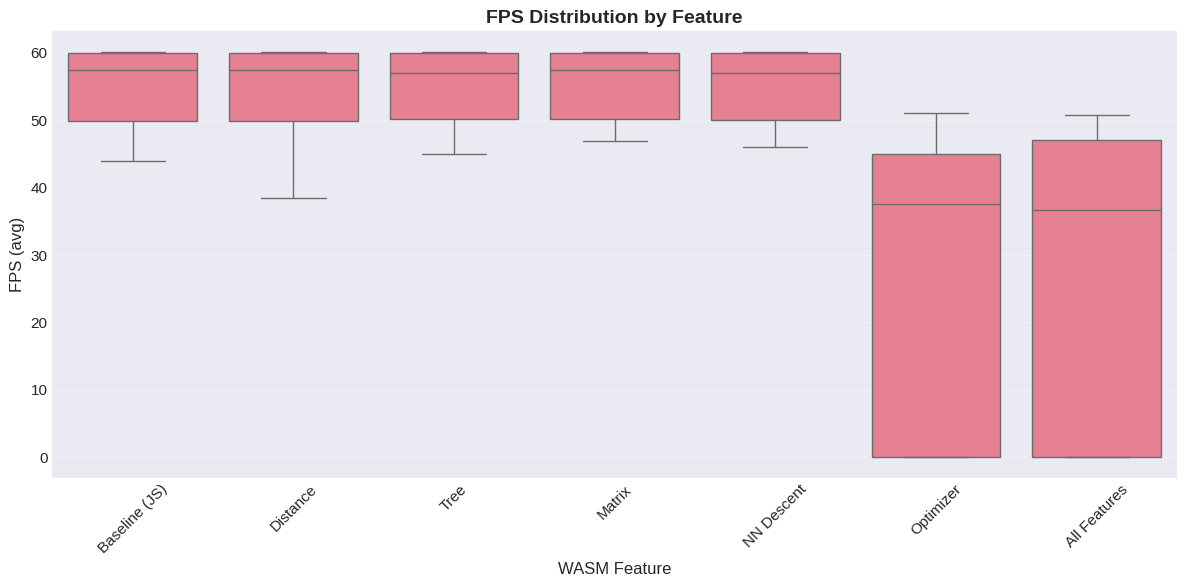

In [97]:
# Visualize FPS distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('FPS Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('FPS (avg)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/fps_distribution.png', bbox_inches='tight')
plt.show()


## 6. Comparative Analysis: Speedup Calculations

Compare all features relative to the baseline.

In [98]:
def calculate_speedup(df, baseline_feature='Baseline (JS)', machine=None):
    """
    Calculate speedup relative to baseline for each machine/dataset combination.
    """
    results = []
    
    # Filter by machine if specified
    data = df[df['machine_type'] == machine] if machine else df
    
    # Group by dataset and machine
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

# Calculate speedups
speedup_df = calculate_speedup(df_analysis)

print("Speedup Summary:")
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary

Speedup Summary:


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.327  1.732  1.316  1.196  4.355         132.662  73.221
Distance       0.998  1.001  0.014  0.970  1.011          -0.225   0.099
Matrix         1.020  1.009  0.033  0.998  1.088           2.042   0.916
NN Descent     0.996  0.998  0.012  0.978  1.015          -0.365  -0.234
Optimizer      2.350  1.615  1.449  1.178  4.534         135.035  61.541
Tree           1.017  1.005  0.034  0.996  1.085           1.668   0.496

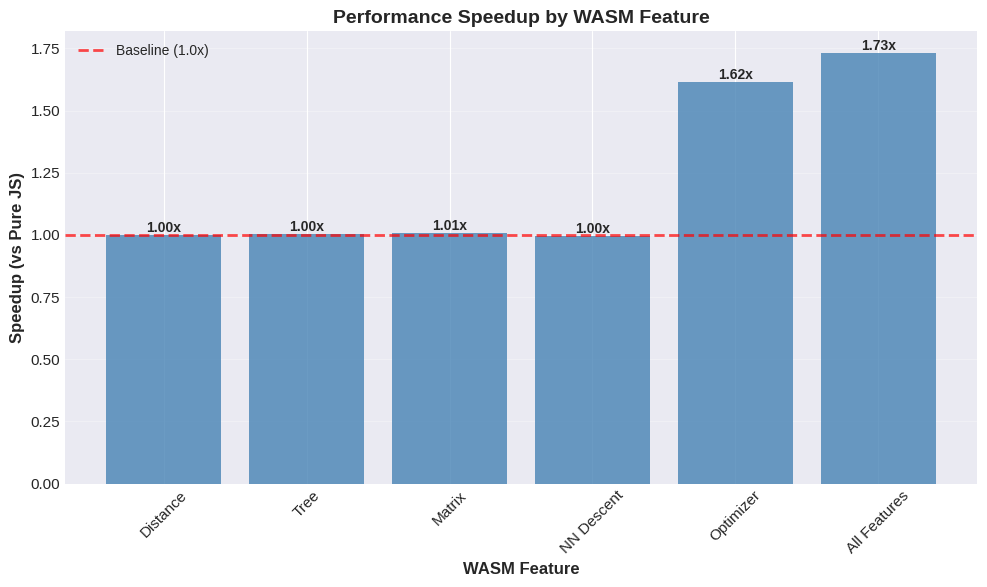

In [99]:
# Detailed speedup by feature
feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_df['feature'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median()
values = [feature_speedups.get(f, 0) for f in feature_order]

bars = ax.bar(feature_order, values, alpha=0.8, color='steelblue')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}x',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (vs Pure JS)', fontsize=12, fontweight='bold')
ax.set_title('Performance Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_comparison.png', bbox_inches='tight')
plt.show()

## 7. Dataset Size Analysis

Analyze how performance scales with dataset size and whether WASM features show different benefits for small vs large datasets.

In [100]:
# Extract dataset size information from the existing 'dataset_size' column
# This column is already in the CSV from the benchmark runs
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Benchmark dataset sizes:
# Small scope: Iris (150), Small Random (80)
# Mid scope: Swiss Roll (600), Medium Clustered (600)
# Large scope: MNIST-like (1000), 3D Dense Clusters (1000)

# Create size categories based on actual benchmark dataset sizes
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'], 
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category distribution:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category distribution:
size_category
Small (≤200)        280
Medium (200-800)    280
Large (>800)        280
Name: count, dtype: int64


In [101]:
# Analyze runtime by dataset size and feature
size_performance = df_analysis.groupby(['dataset_name', 'dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std', 'count']
}).round(2)

print("Runtime by Dataset Size and Feature:")
print("\nSummary statistics:")
size_summary = df_analysis.groupby(['dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std']
}).round(2)
size_summary

Runtime by Dataset Size and Feature:

Summary statistics:


runtime_ms                 
                                 mean   median     std
dataset_size feature_name                             
80           All Features      761.62   752.05   32.86
             Baseline (JS)    3245.07  3275.50  171.03
             Distance         3373.61  3376.00   97.95
             Matrix           3111.43  3011.95  158.20
             NN Descent       3191.77  3275.75  184.05
             Optimizer         731.95   722.45   34.46
             Tree             3111.14  3017.75  166.73
150          All Features      661.79   661.30   29.17
             Baseline (JS)    2373.95  2375.50   29.28
             Distance         2381.26  2376.45   29.96
             Matrix           2367.32  2359.70   35.09
             NN Descent       2386.58  2383.90   18.89
             Optimizer         622.50   619.50   19.20
             Tree             2367.44  2370.20   23.46
600          All Features     1940.36  1868.60  334.04
             Baseline (JS)    3362.44  3351.00  382.07
             Distance         3368.54  3385.85  374.84
             Matrix           3360.10  3336.00  402.67
             NN Descent       3384.18  3384.35  380.23
             Optimizer        2058.15  2039.30  383.06
             Tree             3391.83  3389.35  400.78
1000         All Features     3688.82  3668.30  241.93
             Baseline (JS)    4731.87  4664.85  375.54
             Distance         4699.74  4649.15  260.57
             Matrix           4628.61  4651.50  194.27
             NN Descent       4707.87  4681.25  187.08
             Optimizer        3743.73  3720.25  311.00
             Tree             4587.34  4624.70  200.99

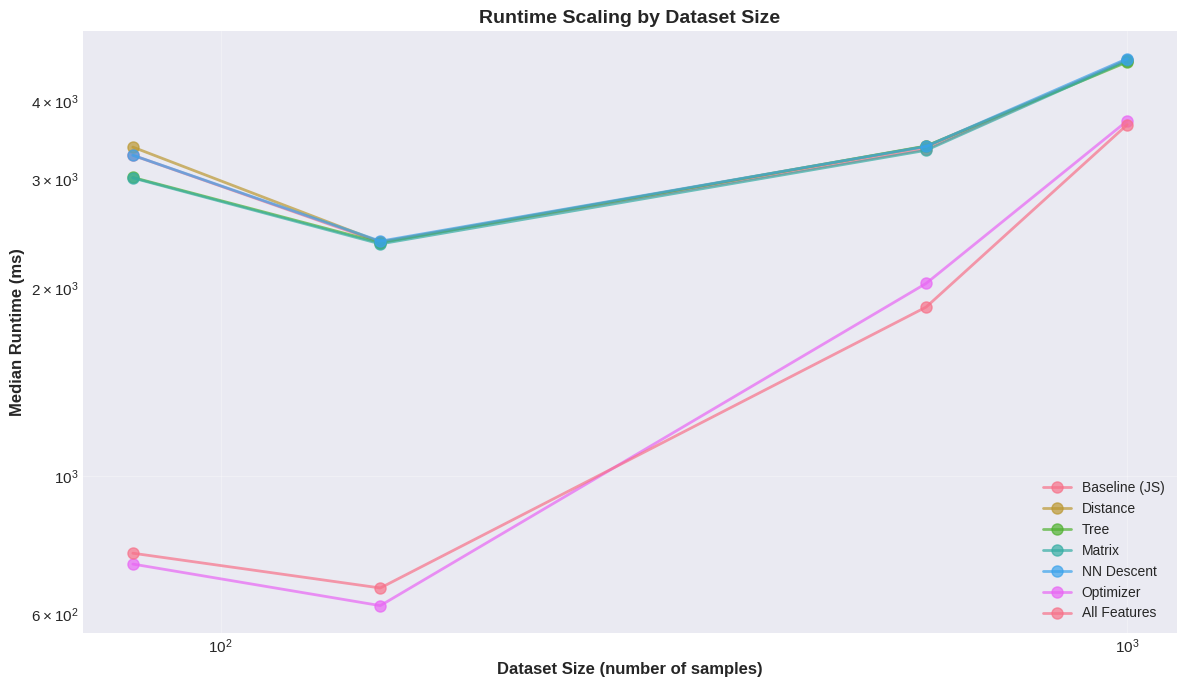

Note: Log-log scale used to show scaling behavior across different dataset sizes.


In [102]:
# Visualize runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Group by dataset size and calculate median runtime
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    
    ax.plot(size_runtime.index, size_runtime.values, 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Log-log scale used to show scaling behavior across different dataset sizes.")

In [103]:
# Analyze speedup by dataset size
def calculate_speedup_by_size(df, baseline_feature='Baseline (JS)'):
    """
    Calculate speedup relative to baseline for each dataset size.
    """
    results = []
    
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'machine': machine,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_by_size_df = calculate_speedup_by_size(df_analysis)

print("Speedup by Dataset Size:")
print("\nAverage speedup across size categories:")
speedup_summary_by_size = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary_by_size

Speedup by Dataset Size:

Average speedup across size categories:


speedup               improvement_pct         
                mean median    std            mean   median
feature                                                    
All Features   2.753  2.693  1.459         175.315  169.274
Distance       0.991  0.995  0.015          -0.927   -0.535
Matrix         1.025  1.006  0.041           2.539    0.560
NN Descent     0.996  0.996  0.004          -0.424   -0.351
Optimizer      2.816  2.739  1.613         181.639  173.888
Tree           1.021  1.005  0.044           2.125    0.546

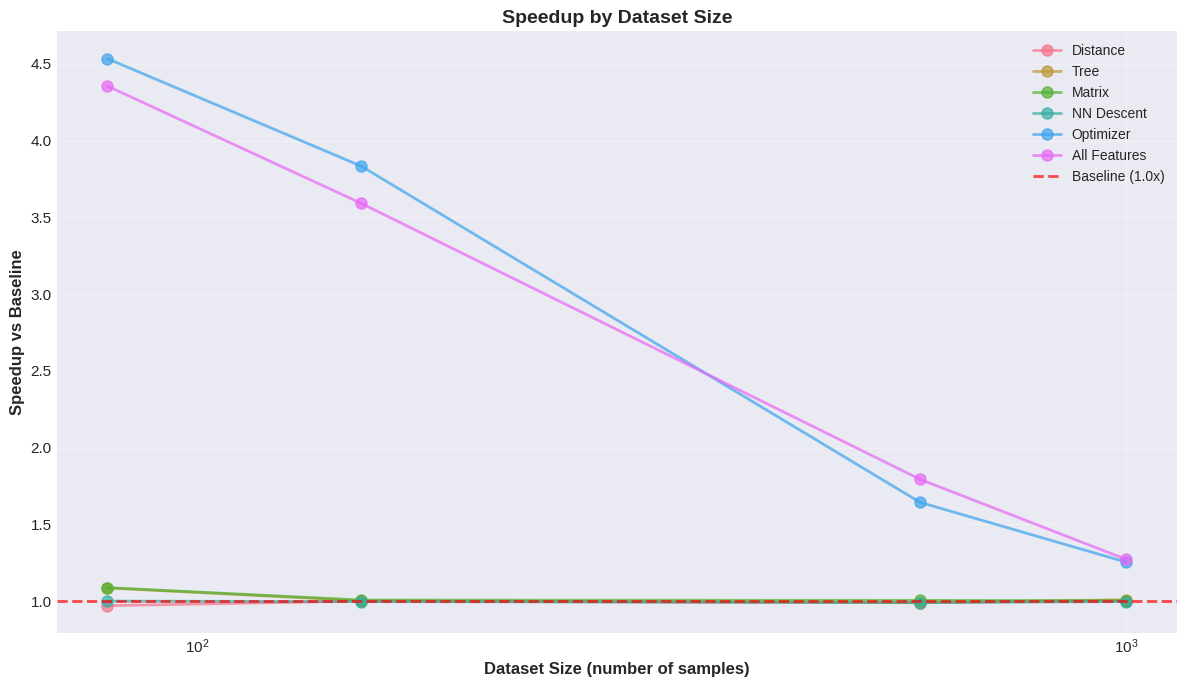

Note: Shows whether WASM benefits increase or decrease with dataset size.


In [104]:
# Visualize speedup trends by dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_by_size_df['feature'].unique()]

for feature in feature_order:
    feature_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Sort by dataset size
    feature_data = feature_data.sort_values('dataset_size')
    
    ax.plot(feature_data['dataset_size'], feature_data['speedup'], 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_dataset_size.png', bbox_inches='tight')
plt.show()

print("Note: Shows whether WASM benefits increase or decrease with dataset size.")

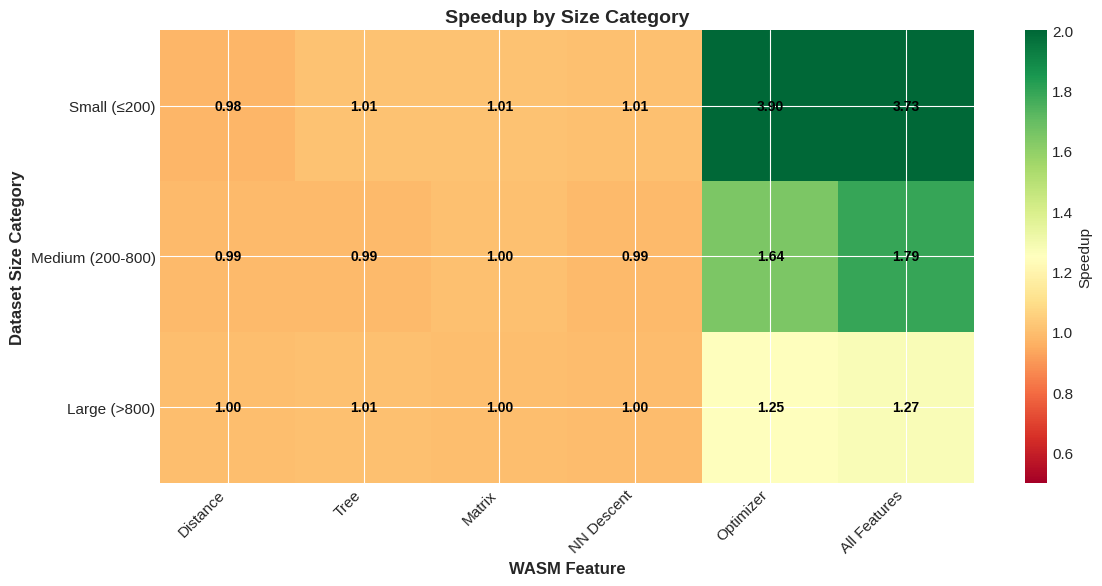

Note: Green = faster than baseline, Red = slower than baseline


In [105]:
# Heatmap of speedup by size category and feature
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate speedup for each size category and feature
speedup_matrix = []
size_cats = df_analysis['size_category'].dropna().unique()
size_cats = sorted(size_cats, key=lambda x: ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'].index(x) if x in ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'] else 999)

for size_cat in size_cats:
    size_data = df_analysis[df_analysis['size_category'] == size_cat]
    baseline = size_data[size_data['feature_name'] == 'Baseline (JS)']['runtime_ms'].median()
    
    if pd.isna(baseline) or baseline == 0:
        continue
    
    row = []
    for feature in feature_order:
        feature_data = size_data[size_data['feature_name'] == feature]
        if len(feature_data) > 0:
            speedup = baseline / feature_data['runtime_ms'].median()
            row.append(speedup)
        else:
            row.append(np.nan)
    
    if row:
        speedup_matrix.append(row)

if speedup_matrix:
    speedup_matrix = np.array(speedup_matrix)
    
    im = ax.imshow(speedup_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=2.0)
    ax.set_xticks(np.arange(len(feature_order)))
    ax.set_yticks(np.arange(len(size_cats[:len(speedup_matrix)])))
    ax.set_xticklabels(feature_order, rotation=45, ha='right')
    ax.set_yticklabels(size_cats[:len(speedup_matrix)])
    ax.set_title('Speedup by Size Category', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset Size Category', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(speedup_matrix)):
        for j in range(len(feature_order)):
            if not np.isnan(speedup_matrix[i, j]):
                text = ax.text(j, i, f'{speedup_matrix[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Speedup', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_heatmap_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Green = faster than baseline, Red = slower than baseline")

In [106]:
# Summary statistics: Speedup by size category
print("=" * 80)
print("DATASET SIZE ANALYSIS SUMMARY")
print("=" * 80)

# Group by feature and calculate statistics
size_analysis = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'min', 'max', 'std']
}).round(3)

print(size_analysis)

# Find which features scale better with size
print(f"\nScaling behavior:")
for feature in speedup_by_size_df['feature'].unique():
    feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) > 1:
        # Simple trend: compare smallest vs largest
        small_speedup = feat_data.iloc[0]['speedup']
        large_speedup = feat_data.iloc[-1]['speedup']
        trend = "improves" if large_speedup > small_speedup else "degrades"
        print(f"  {feature}: {trend} with size ({small_speedup:.2f}x → {large_speedup:.2f}x)")

print("\n" + "=" * 80)

DATASET SIZE ANALYSIS SUMMARY
             speedup                            
                mean median    min    max    std
feature                                         
All Features   2.753  2.693  1.272  4.355  1.459
Distance       0.991  0.995  0.970  1.003  0.015
Matrix         1.025  1.006  1.003  1.088  0.041
NN Descent     0.996  0.996  0.990  1.000  0.004
Optimizer      2.816  2.739  1.254  4.534  1.613
Tree           1.021  1.005  0.989  1.085  0.044

Scaling behavior:
  All Features: degrades with size (4.36x → 1.27x)
  Distance: improves with size (0.97x → 1.00x)
  Tree: degrades with size (1.09x → 1.01x)
  Matrix: degrades with size (1.09x → 1.00x)
  NN Descent: degrades with size (1.00x → 1.00x)
  Optimizer: degrades with size (4.53x → 1.25x)



## 8. Statistical Testing

Perform rigorous statistical tests to determine if differences are significant.

In [107]:
def mann_whitney_test(df, baseline_feature='Baseline (JS)'):
    """
    Perform Mann-Whitney U test comparing each feature to baseline.
    """
    results = []
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna()
    
    if len(baseline) < 3:
        print("Insufficient baseline data for testing")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna()
        
        if len(feature_data) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(baseline, feature_data, alternative='two-sided')
        
        # Effect size (Cohen's d approximation)
        mean_diff = feature_data.mean() - baseline.mean()
        pooled_std = np.sqrt((baseline.std()**2 + feature_data.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Cliff's Delta (effect size for non-parametric test)
        n1, n2 = len(baseline), len(feature_data)
        pairs_greater = sum(1 for b in baseline for f in feature_data if b > f)
        pairs_less = sum(1 for b in baseline for f in feature_data if b < f)
        cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
        
        results.append({
            'feature': feature,
            'n_baseline': len(baseline),
            'n_feature': len(feature_data),
            'baseline_median': baseline.median(),
            'feature_median': feature_data.median(),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'cliffs_delta': cliffs_delta
        })
    
    return pd.DataFrame(results)

# Perform tests
test_results = mann_whitney_test(df_analysis)

print("Statistical Test Results (Mann-Whitney U Test):")
print("\nSignificance: p < 0.05")
print("Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)\n")
test_results.round(4)

Statistical Test Results (Mann-Whitney U Test):

Significance: p < 0.05
Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)



,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cohens_d,cliffs_delta
0,All Features,120,120,3575.5,1868.60,0.000,True,-1.393,0.607
1,Distance,120,120,3575.5,3570.95,0.782,False,0.016,-0.021
2,Tree,120,120,3575.5,3538.05,0.534,False,-0.071,0.046
3,Matrix,120,120,3575.5,3438.10,0.462,False,-0.066,0.055
4,NN Descent,120,120,3575.5,3489.85,0.847,False,-0.009,-0.014
5,Optimizer,120,120,3575.5,2039.30,0.000,True,-1.322,0.585


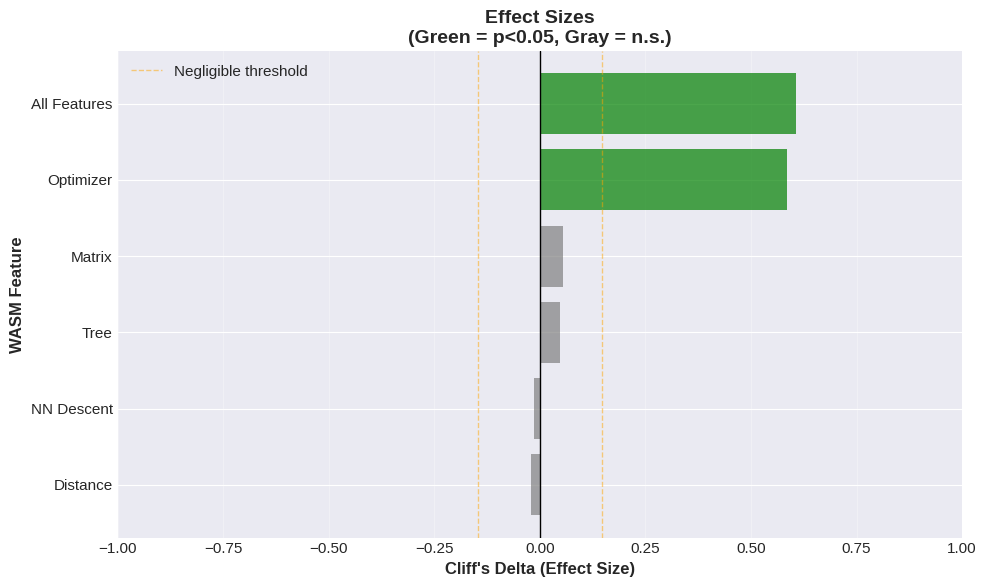

Note: Negative Cliff's Delta = feature is faster than baseline
      Positive Cliff's Delta = feature is slower than baseline


In [108]:
# Visualize statistical significance
fig, ax = plt.subplots(figsize=(10, 6))

if len(test_results) > 0:
    # Sort by Cliff's delta
    test_results_sorted = test_results.sort_values('cliffs_delta')
    
    colors = ['green' if sig else 'gray' for sig in test_results_sorted['significant']]
    
    ax.barh(test_results_sorted['feature'], test_results_sorted['cliffs_delta'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Negligible threshold')
    ax.axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=12, fontweight='bold')
    ax.set_ylabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_title('Effect Sizes\n(Green = p<0.05, Gray = n.s.)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/effect_sizes.png', bbox_inches='tight')
plt.show()

print("Note: Negative Cliff's Delta = feature is faster than baseline")
print("      Positive Cliff's Delta = feature is slower than baseline")

## 9. Bootstrap Confidence Intervals

Calculate robust confidence intervals for median speedups using bootstrap resampling.

In [109]:
def bootstrap_speedup_ci(df, baseline_feature='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for speedup.
    """
    results = []
    rng = np.random.default_rng(42)
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna().values
    
    if len(baseline) < 3:
        print("Insufficient baseline data for bootstrap")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna().values
        
        if len(feature_data) < 3:
            continue
        
        # Bootstrap speedup
        speedups = []
        for _ in range(n_bootstrap):
            base_sample = rng.choice(baseline, size=len(baseline), replace=True)
            feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
            speedup = np.median(base_sample) / np.median(feat_sample)
            speedups.append(speedup)
        
        speedups = np.array(speedups)
        alpha = 1 - confidence
        ci_lower = np.percentile(speedups, alpha/2 * 100)
        ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
        
        results.append({
            'feature': feature,
            'speedup_median': np.median(speedups),
            'speedup_mean': np.mean(speedups),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        })
    
    return pd.DataFrame(results)

# Calculate bootstrap CIs
print("Calculating bootstrap confidence intervals (10,000 iterations)...")
bootstrap_results = bootstrap_speedup_ci(df_analysis)

print("\nBootstrap 95% Confidence Intervals for Speedup:\n")
bootstrap_results.round(3)

Calculating bootstrap confidence intervals (10,000 iterations)...

Bootstrap 95% Confidence Intervals for Speedup:



,feature,speedup_median,speedup_mean,ci_lower,ci_upper,ci_width
0,All Features,1.891,1.892,1.508,2.212,0.704
1,Distance,0.997,0.995,0.899,1.090,0.191
2,Tree,1.012,1.019,0.894,1.161,0.267
3,Matrix,1.023,1.030,0.909,1.161,0.252
4,NN Descent,1.009,1.012,0.903,1.120,0.217
5,Optimizer,1.722,1.765,1.413,2.121,0.708


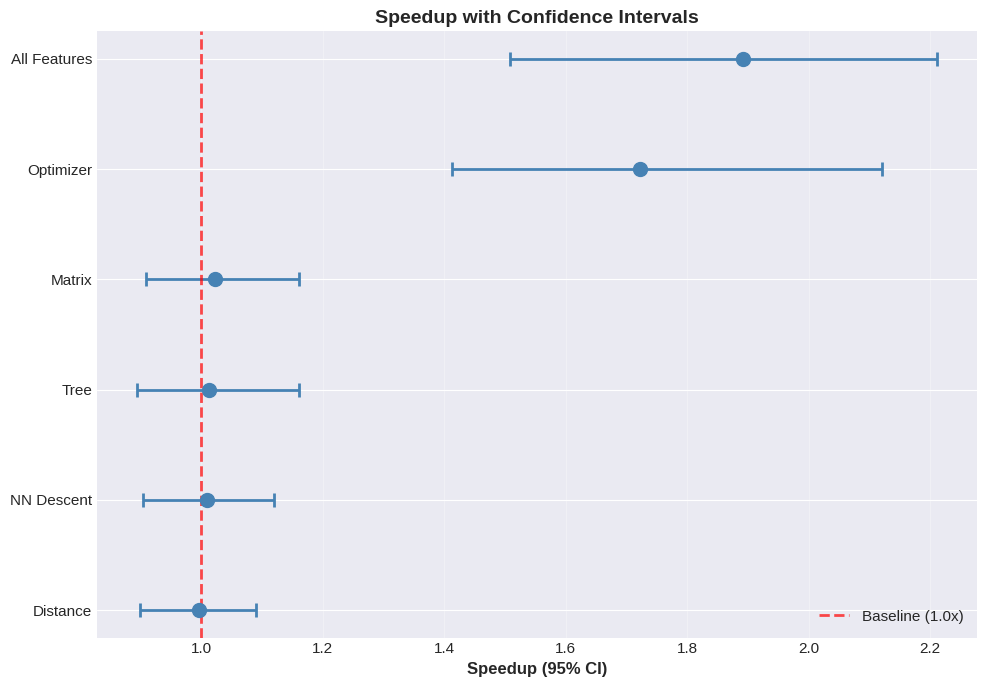

In [110]:
# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(10, 7))

if len(bootstrap_results) > 0:
    bootstrap_results_sorted = bootstrap_results.sort_values('speedup_median')
    
    y_pos = np.arange(len(bootstrap_results_sorted))
    
    # Plot error bars
    ax.errorbar(
        bootstrap_results_sorted['speedup_median'],
        y_pos,
        xerr=[
            bootstrap_results_sorted['speedup_median'] - bootstrap_results_sorted['ci_lower'],
            bootstrap_results_sorted['ci_upper'] - bootstrap_results_sorted['speedup_median']
        ],
        fmt='o',
        markersize=10,
        capsize=5,
        capthick=2,
        elinewidth=2,
        color='steelblue'
    )
    
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bootstrap_results_sorted['feature'])
    ax.set_xlabel('Speedup (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title('Speedup with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_confidence_intervals.png', bbox_inches='tight')
plt.show()

## 10. Quality and Responsiveness Analysis

Analyze the trade-offs between performance and output quality/responsiveness.

In [111]:
# Quality comparison
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

quality_summary = df_analysis.groupby('feature_name').agg({
    'trustworthiness': ['mean', 'median', 'std', 'count'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(4)

print("Quality and Responsiveness by Feature:\n")
quality_summary

Quality and Responsiveness by Feature:



trustworthiness                     fps_avg         responsiveness_ms        
                         mean median    std count    mean  median              mean  median
feature_name                                                                               
All Features            0.890  0.966  0.153   120  27.887  36.649            32.547  19.850
Baseline (JS)           0.901  0.969  0.139   120  55.165  57.425            35.478  21.337
Distance                0.901  0.970  0.139   120  54.913  57.446            35.938  21.610
Matrix                  0.900  0.970  0.140   120  55.209  57.426            33.227  20.143
NN Descent              0.899  0.970  0.141   120  55.096  57.000            35.397  20.697
Optimizer               0.888  0.967  0.156   120  28.032  37.613            35.464  21.044
Tree                    0.900  0.968  0.139   120  55.235  56.978            34.264  21.170

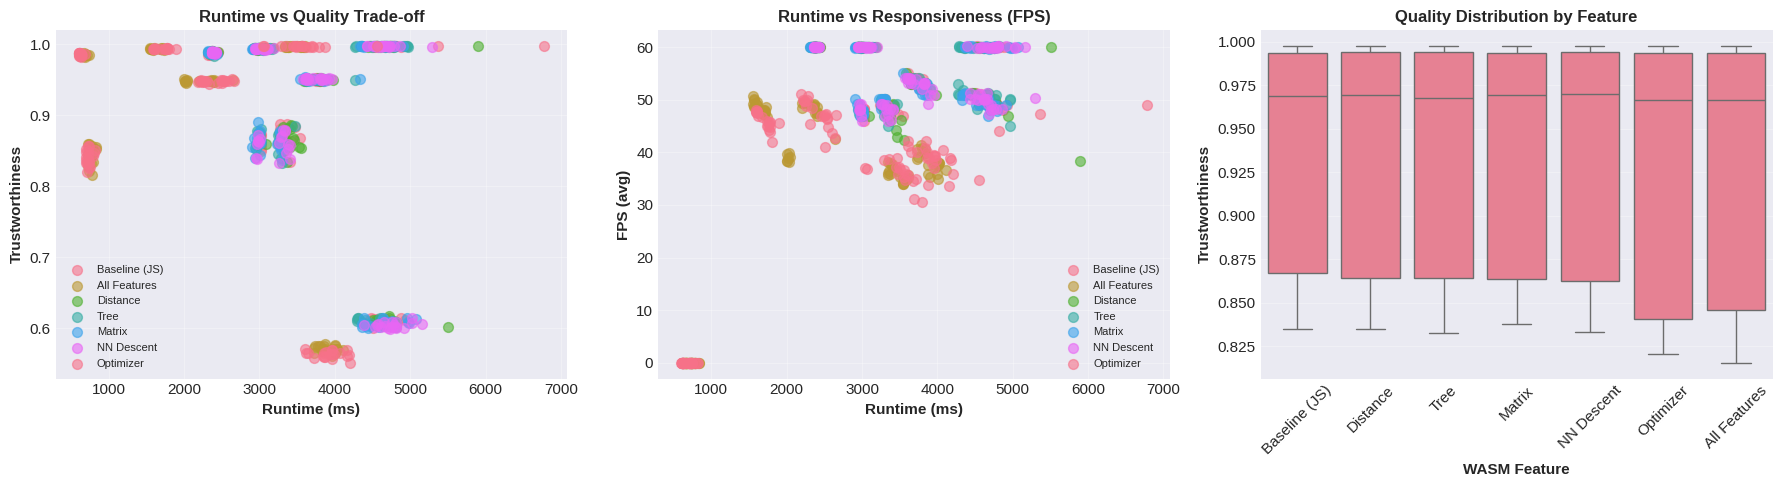

In [112]:
# Visualize quality vs performance trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Runtime vs Quality
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[0].scatter(feature_data['runtime_ms'], feature_data['trustworthiness'], 
                   label=feature, alpha=0.6, s=50)

axes[0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[0].set_title('Runtime vs Quality Trade-off', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(alpha=0.3)

# Runtime vs FPS
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[1].scatter(feature_data['runtime_ms'], feature_data['fps_avg'], 
                   label=feature, alpha=0.6, s=50)

axes[1].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1].set_title('Runtime vs Responsiveness (FPS)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(alpha=0.3)

# Quality by feature (boxplot)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[2], showfliers=False)
axes[2].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[2].set_title('Quality Distribution by Feature', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/quality_tradeoffs.png', bbox_inches='tight')
plt.show()

## 11. Feature Ranking and Recommendations

Rank features based on multiple criteria for practical recommendations.

In [113]:
# Calculate composite scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    """
    Calculate composite performance scores for each feature.
    """
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Calculate metrics relative to baseline
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median()
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median()
        
        # Memory impact (negative is better)
        memory_delta = feature_data['memory_delta_mb'].median()
        
        # Composite score (higher is better)
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 
                    0.25 * quality_ratio + 
                    0.15 * fps_ratio - 
                    0.10 * abs(memory_delta / 10))  # Normalize memory
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_delta_mb': memory_delta,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

# Calculate rankings
print("Feature Rankings by Composite Score:\n")
print('='*70)
rankings = calculate_composite_scores(df_analysis)
print(rankings.round(3).to_string(index=False))

Feature Rankings by Composite Score:

     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
All Features    1.913          0.997      0.638           12.572            1.176
   Optimizer    1.753          0.998      0.655            5.277            1.172
      Matrix    1.040          1.001      1.000           13.048            0.790
    Distance    1.001          1.001      1.000           12.131            0.780
        Tree    1.011          0.999      0.992           12.554            0.778
  NN Descent    1.025          1.001      0.993           16.872            0.743


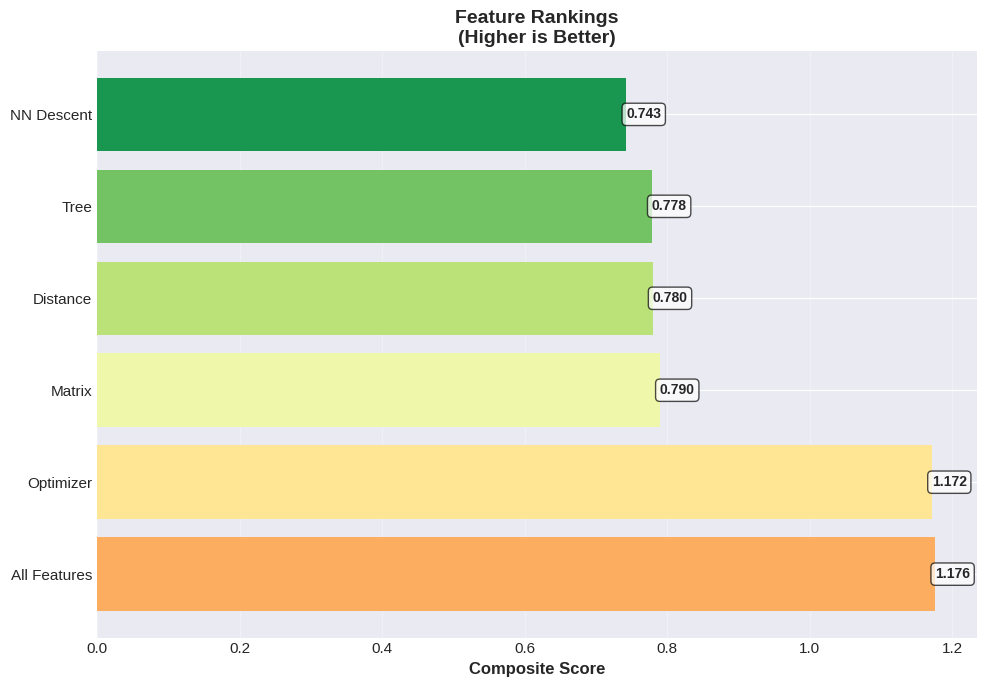

In [114]:
# Visualize feature rankings
fig, ax = plt.subplots(figsize=(10, 7))

rankings = calculate_composite_scores(df_analysis)

if len(rankings) > 0:
    # Create color gradient
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    ax.set_xlabel('Composite Score', fontsize=12, fontweight='bold')
    ax.set_title('Feature Rankings\n(Higher is Better)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('../outputs/figures/feature_rankings.png', bbox_inches='tight')
plt.show()

## 12. Summary Statistics and Export

Generate comprehensive summary tables for thesis inclusion.

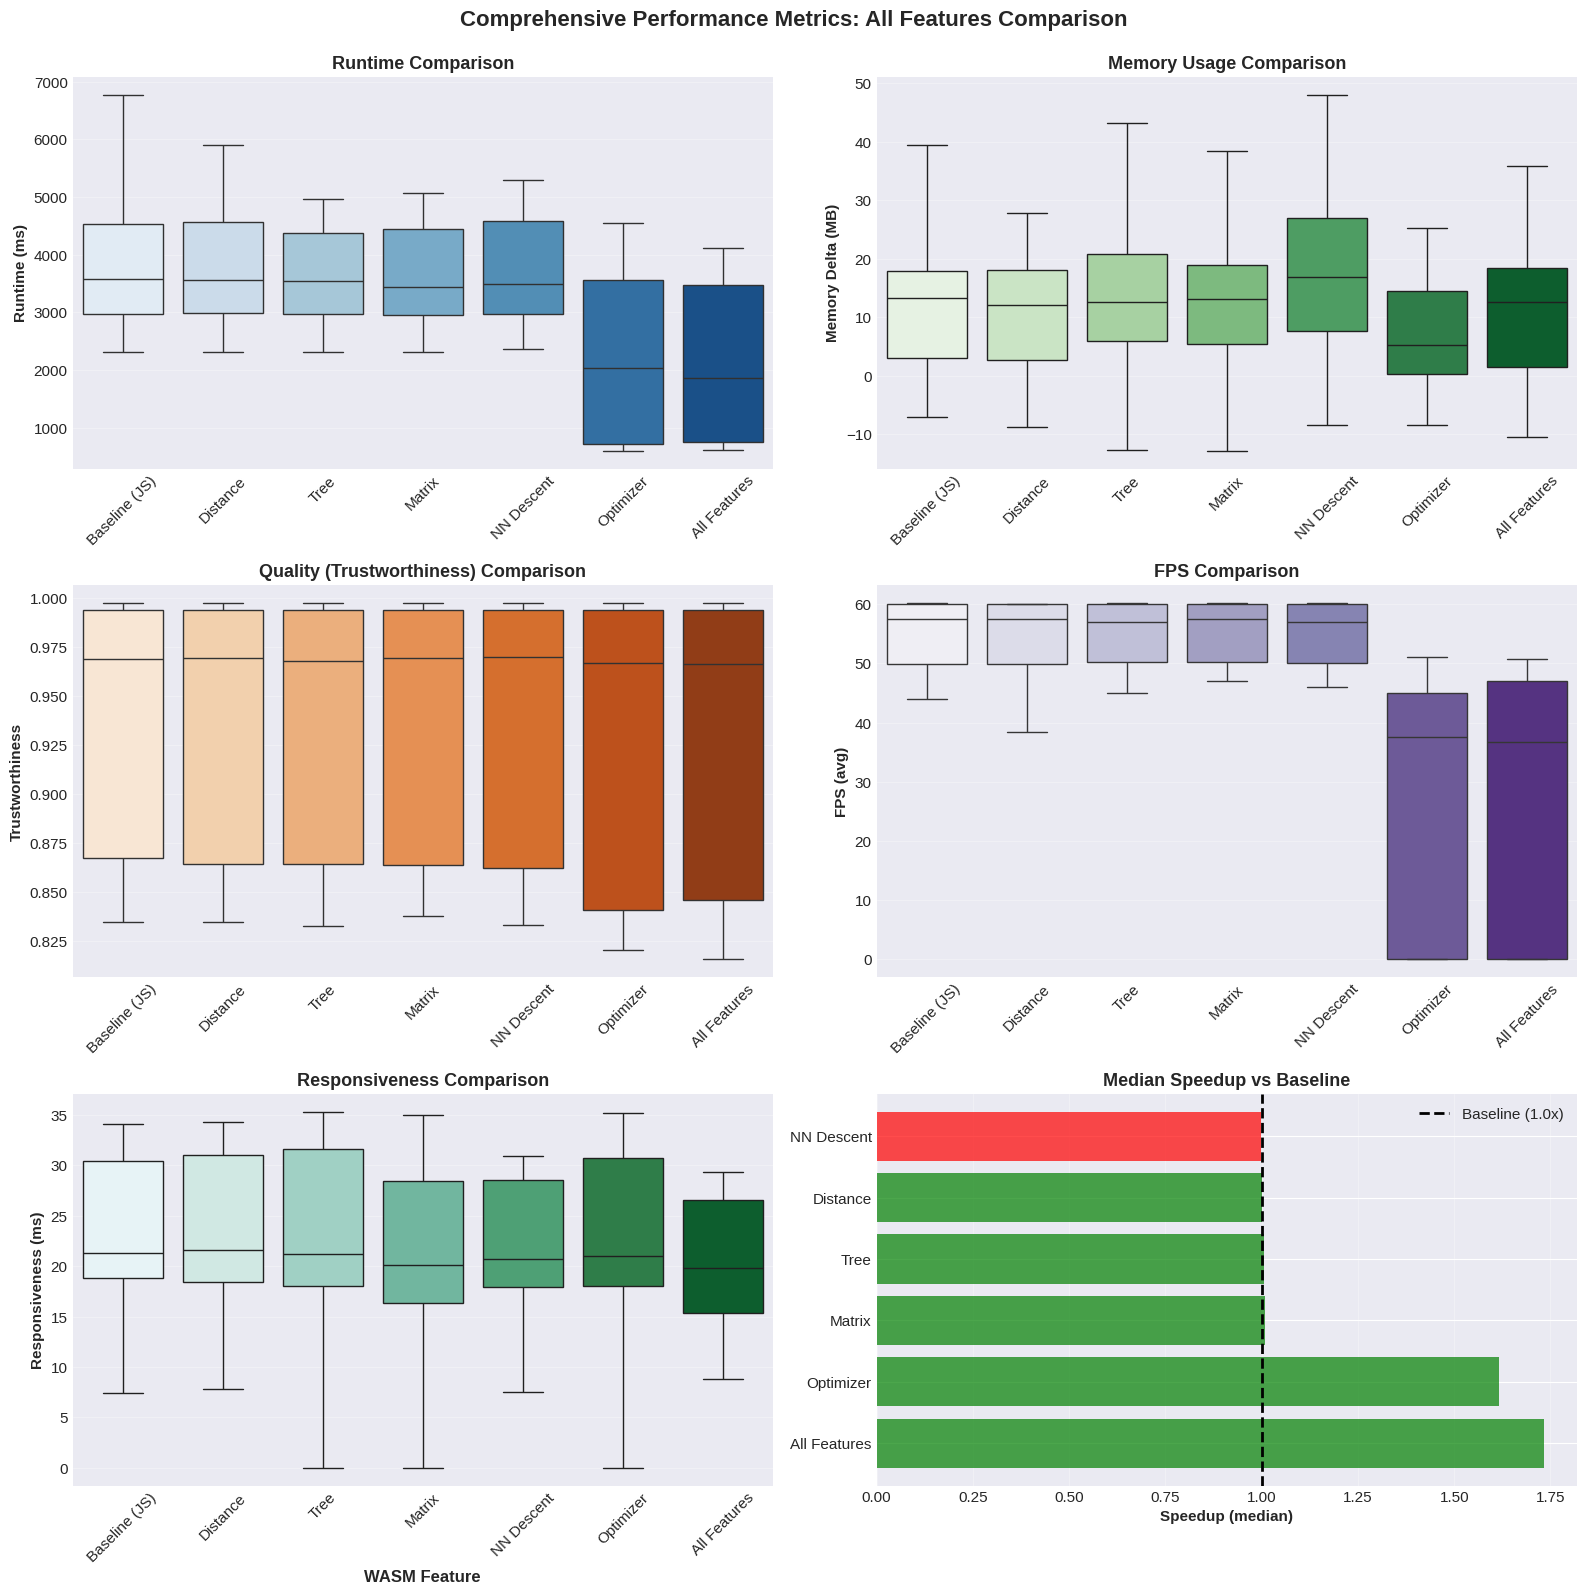

Comprehensive multi-metric comparison visualization created!


In [115]:
# Comprehensive comparison of all metrics
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

# 1. Runtime
sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=axes[0, 0], showfliers=False, palette='Blues')
axes[0, 0].set_title('Runtime Comparison', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Memory
sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', 
            order=feature_order, ax=axes[0, 1], showfliers=False, palette='Greens')
axes[0, 1].set_title('Memory Usage Comparison', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Quality (Trustworthiness)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[1, 0], showfliers=False, palette='Oranges')
axes[1, 0].set_title('Quality (Trustworthiness) Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. FPS
sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', 
            order=feature_order, ax=axes[1, 1], showfliers=False, palette='Purples')
axes[1, 1].set_title('FPS Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# 5. Responsiveness
sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', 
            order=feature_order, ax=axes[2, 0], showfliers=False, palette='BuGn')
axes[2, 0].set_title('Responsiveness Comparison', fontsize=13, fontweight='bold')
axes[2, 0].set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(axis='y', alpha=0.3)

# 6. Speedup Bar Chart
if len(speedup_df) > 0:
    speedup_by_feature = speedup_df.groupby('feature')['speedup'].median().sort_values(ascending=False)
    colors_speedup = ['green' if x > 1 else 'red' for x in speedup_by_feature.values]
    
    axes[2, 1].barh(speedup_by_feature.index, speedup_by_feature.values, color=colors_speedup, alpha=0.7)
    axes[2, 1].axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1.0x)')
    axes[2, 1].set_xlabel('Speedup (median)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Median Speedup vs Baseline', fontsize=13, fontweight='bold')
    axes[2, 1].grid(axis='x', alpha=0.3)
    axes[2, 1].legend()
else:
    axes[2, 1].text(0.5, 0.5, 'No speedup data available', 
                    ha='center', va='center', transform=axes[2, 1].transAxes)
    axes[2, 1].set_title('Speedup Comparison', fontsize=13, fontweight='bold')

plt.suptitle('Comprehensive Performance Metrics: All Features Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../outputs/figures/comprehensive_metrics_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("Comprehensive multi-metric comparison visualization created!")


### Comprehensive Multi-Metric Comparison

Visual comparison of all performance and quality metrics across features.

In [116]:
# Create output directory
os.makedirs('../outputs/summaries', exist_ok=True)

# Export all summary tables
speedup_df.to_csv('../outputs/summaries/speedup_summary.csv', index=False)
test_results.to_csv('../outputs/summaries/statistical_tests.csv', index=False)
bootstrap_results.to_csv('../outputs/summaries/bootstrap_confidence_intervals.csv', index=False)
quality_summary.to_csv('../outputs/summaries/quality_summary.csv')

# Export rankings
rankings = calculate_composite_scores(df_analysis)
rankings.to_csv('../outputs/summaries/rankings.csv', index=False)

print("All results exported to ../outputs/ directory")

All results exported to ../outputs/ directory


In [117]:
# Generate thesis-ready summary

summary_md = f"""
# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: {len(df_analysis):,}
- **Datasets Tested**: {df_analysis['dataset_name'].nunique()}
- **Features Tested**: {df_analysis['feature_name'].nunique()}

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**
"""

if len(speedup_df) > 0:
    for feature in speedup_df['feature'].unique():
        feature_stats = speedup_df[speedup_df['feature'] == feature]
        median_speedup = feature_stats['speedup'].median()
        min_speedup = feature_stats['speedup'].min()
        max_speedup = feature_stats['speedup'].max()
        
        # Determine if improvement or regression
        if median_speedup > 1.05:
            verdict = "✓ Performance improvement"
        elif median_speedup < 0.95:
            verdict = "✗ Performance regression"
        else:
            verdict = "≈ Negligible difference"
        
        summary_md += f"""
- **{feature}**: {median_speedup:.2f}x (range: {min_speedup:.2f}x - {max_speedup:.2f}x) - {verdict}
"""
else:
    summary_md += "\n*Insufficient data for speedup analysis*\n"

summary_md += f"""

### RQ2: All Features Combined vs Individual Features

"""

if len(speedup_df) > 0 and 'All Features' in speedup_df['feature'].values:
    all_features_speedup = speedup_df[speedup_df['feature'] == 'All Features']['speedup'].median()
    # Exclude 'All Features' when finding best individual feature
    individual_features = speedup_df[speedup_df['feature'] != 'All Features']
    if len(individual_features) > 0:
        best_speedup = individual_features.groupby('feature')['speedup'].median().max()
        best_feature = individual_features.groupby('feature')['speedup'].median().idxmax()
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
- **Best Individual Feature**: {best_feature} ({best_speedup:.2f}x)
- **Comparison**: {'All Features is best' if all_features_speedup >= best_speedup else f'{best_feature} outperforms All Features'}
"""
    else:
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
"""
else:
    summary_md += """
- *Insufficient data for "All Features" comparison*
"""

summary_md += f"""

### Statistical Significance

"""

if len(test_results) > 0:
    summary_md += f"""
- **Total comparisons**: {len(test_results)}
- **Significant results (p < 0.05)**: {test_results['significant'].sum()} ({test_results['significant'].sum()/len(test_results)*100:.1f}%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: {(abs(test_results['cliffs_delta']) > 0.474).sum()}
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: {((abs(test_results['cliffs_delta']) > 0.33) & (abs(test_results['cliffs_delta']) <= 0.474)).sum()}
"""
else:
    summary_md += "\n*Insufficient data for statistical testing*\n"

summary_md += """

### Quality Trade-offs

"""

summary_md += f"""
- **Mean Trustworthiness**: {df_analysis['trustworthiness'].mean():.4f} (±{df_analysis['trustworthiness'].std():.4f})
- **Quality Range**: {df_analysis['trustworthiness'].min():.4f} - {df_analysis['trustworthiness'].max():.4f}
- **Quality Stability**: All features maintain trustworthiness > {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f}

### Performance Rankings

**Top 3 Features by Composite Score:**
"""

rankings = calculate_composite_scores(df_analysis)
if len(rankings) > 0:
    for rank, (idx, row) in enumerate(rankings.head(3).iterrows(), 1):
        summary_md += f"""
{rank}. **{row['feature']}** (score: {row['composite_score']:.3f})
   - Speedup: {row['speedup']:.2f}x
   - Quality ratio: {row['quality_ratio']:.3f}
   - FPS ratio: {row['fps_ratio']:.3f}
"""
else:
    summary_md += "\n*Insufficient data for feature ranking*\n"

summary_md += f"""

## Dataset Size Effects

**Scaling behavior across dataset sizes ({df_analysis['dataset_size'].min():.0f} - {df_analysis['dataset_size'].max():.0f} samples):**

"""

if len(speedup_by_size_df) > 0:
    for feature in speedup_by_size_df['feature'].unique():
        feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
        if len(feat_data) > 1:
            small_speedup = feat_data.iloc[0]['speedup']
            large_speedup = feat_data.iloc[-1]['speedup']
            trend = "improves" if large_speedup > small_speedup else "degrades"
            change_pct = ((large_speedup - small_speedup) / small_speedup * 100)
            summary_md += f"- **{feature}**: {trend} ({small_speedup:.2f}x → {large_speedup:.2f}x, {change_pct:+.1f}%)\n"
        else:
            summary_md += f"- **{feature}**: Insufficient data for trend analysis\n"
else:
    summary_md += "\n*Insufficient data for dataset size analysis*\n"

summary_md += f"""

## Recommendations

"""

if len(rankings) > 0 and len(speedup_df) > 0:
    summary_md += f"""
1. **Best Overall Performance**: {rankings.iloc[0]['feature']} (composite score: {rankings.iloc[0]['composite_score']:.3f})
2. **Fastest Execution**: {speedup_df.groupby('feature')['speedup'].median().idxmax()} ({speedup_df.groupby('feature')['speedup'].median().max():.2f}x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f})
"""
else:
    summary_md += "\n*Collect more data for comprehensive recommendations*\n"

summary_md += f"""

## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with {len(df_analysis):,} measurements across {df_analysis['dataset_name'].nunique()} datasets*
"""

display(Markdown(summary_md))

# Save summary
with open('../outputs/summaries/thesis_summary.md', 'w') as f:
    f.write(summary_md)

print("\n" + "="*80)
print("Summary saved to: ../outputs/summaries/thesis_summary.md")
print("="*80)


# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: 840
- **Datasets Tested**: 6
- **Features Tested**: 7

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**

- **All Features**: 1.73x (range: 1.20x - 4.36x) - ✓ Performance improvement

- **Distance**: 1.00x (range: 0.97x - 1.01x) - ≈ Negligible difference

- **Tree**: 1.00x (range: 1.00x - 1.09x) - ≈ Negligible difference

- **Matrix**: 1.01x (range: 1.00x - 1.09x) - ≈ Negligible difference

- **NN Descent**: 1.00x (range: 0.98x - 1.01x) - ≈ Negligible difference

- **Optimizer**: 1.62x (range: 1.18x - 4.53x) - ✓ Performance improvement


### RQ2: All Features Combined vs Individual Features


- **All Features Combined**: 1.73x median speedup
- **Best Individual Feature**: Optimizer (1.62x)
- **Comparison**: All Features is best


### Statistical Significance


- **Total comparisons**: 6
- **Significant results (p < 0.05)**: 2 (33.3%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: 2
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: 0


### Quality Trade-offs


- **Mean Trustworthiness**: 0.8970 (±0.1433)
- **Quality Range**: 0.5515 - 0.9975
- **Quality Stability**: All features maintain trustworthiness > 0.966

### Performance Rankings

**Top 3 Features by Composite Score:**

1. **All Features** (score: 1.176)
   - Speedup: 1.91x
   - Quality ratio: 0.997
   - FPS ratio: 0.638

2. **Optimizer** (score: 1.172)
   - Speedup: 1.75x
   - Quality ratio: 0.998
   - FPS ratio: 0.655

3. **Matrix** (score: 0.790)
   - Speedup: 1.04x
   - Quality ratio: 1.001
   - FPS ratio: 1.000


## Dataset Size Effects

**Scaling behavior across dataset sizes (80 - 1000 samples):**

- **All Features**: degrades (4.36x → 1.27x, -70.8%)
- **Distance**: improves (0.97x → 1.00x, +3.4%)
- **Tree**: degrades (1.09x → 1.01x, -7.1%)
- **Matrix**: degrades (1.09x → 1.00x, -7.8%)
- **NN Descent**: degrades (1.00x → 1.00x, -0.3%)
- **Optimizer**: degrades (4.53x → 1.25x, -72.3%)


## Recommendations


1. **Best Overall Performance**: All Features (composite score: 1.176)
2. **Fastest Execution**: All Features (1.73x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> 0.966)


## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with 840 measurements across 6 datasets*



Summary saved to: ../outputs/summaries/thesis_summary.md
